# Load data

In [1]:
import os
import pandas as pd
import gzip #zipfile
from datetime import date
def loadMimic(path, nrows = None):
    os.chdir(path)
    with gzip.open('TRANSFERS.csv.gz', 'rt') as read_file:
        data = pd.read_csv(read_file, nrows=nrows)
    with gzip.open('PATIENTS.csv.gz', 'rt') as read_file:
        patients = pd.read_csv(read_file)
    data['event_id'] = data['EVENTTYPE'].astype(str).str.cat(data['CURR_CAREUNIT'].astype(str),sep='_')
    data = pd.merge(data, patients, how='left', on='SUBJECT_ID')
    #convert date of birth to numeric (age)
    data['DOB']=(date.today()-pd.to_datetime(data['DOB'],format="%Y-%m-%d %H:%M:%S")).astype('timedelta64[Y]').astype(int)
    #convert to a timestamp type
    data['INTIME'] = pd.to_datetime(data['INTIME'],format="%Y-%m-%d %H:%M:%S")
    data = data[['SUBJECT_ID','event_id','INTIME','GENDER','DOB']]
    data.dropna(inplace=True)
    return data

def loadSenegal(path,nrows=None):
    os.chdir(path)
    with gzip.open('SET2_P14.CSV.gz', 'rt') as read_file:
        data = pd.read_csv(read_file, nrows=nrows)
    #data = pd.read_csv(read_file,nrows=nrows)
    data.columns=['user_id','timestamp','site_id']
    data['site_id'] = data['site_id'].astype(str)
    #convert to a timestamp type
    data['timestamp'] = pd.to_datetime(data['timestamp'],format="%Y-%m-%d %H:%M:%S")
    data.dropna(inplace=True)
    return data

def loadReducedSenegal(path,nrows=None):
    os.chdir(path)
    read_file = 'senegal2m300states_10grid.txt'
    data = pd.read_csv(read_file, nrows=nrows)
    data.columns=['user_id','timestamp','site_id']
    data['site_id'] = data['site_id'].astype(str)
    #convert to a timestamp type
    data['timestamp'] = pd.to_datetime(data['timestamp'],format="%Y-%m-%d %H:%M:%S")
    data.dropna(inplace=True)
    return data

def loadReducedTaxi(path,nrows=None):
    os.chdir(path)
    with gzip.open('Taxi_300000_FixedGrid.txt.gz', 'rt') as read_file:
        data = pd.read_csv(read_file, nrows=nrows)
    #read_file = 'Taxi_300000_FixedGrid.txt.gz'
    #data = pd.read_csv(read_file, nrows=nrows)
    #data.columns=['user_id','timestamp','site_id']
    data['site_id'] = data['lon'].astype('str')+'_'+data['lat'].astype('str')
    #convert to a timestamp type
    data['timestamp'] = pd.to_datetime(data['timestamp'],format="%Y-%m-%d %H:%M:%S")
    data = data[['TRIP_ID','site_id','timestamp','DAY_TYPE']]
    data.dropna(inplace=True)
    return data

def loadData(dataset, path,nrows=None):
    return {'mimic' : loadMimic,
            'senegal' : loadReducedSenegal,
            'Taxis': loadReducedTaxi
           }[dataset](path,nrows)
#df = loadData('mimic', r'C:\Users\sigal\OneDrive - post.bgu.ac.il\sigal\decision tree based fabrication\mimicIII')
#df = loadData('senegal', r'C:\Users\sigal\OneDrive - post.bgu.ac.il\sigal\decision tree based fabrication\d4d', 50000)
#df = loadData('senegal', r'C:\Users\sigal\OneDrive - post.bgu.ac.il\sigal\submissions\journal\data', 50000)

# Process Data

In [2]:
from datetime import date
import pandas as pd
import math
import scipy
import numpy as np
from collections import Counter
#using xgboost
import xgboost as xgb
import sklearn.preprocessing  as preprocessing
#using decision tree
from sklearn import tree
#using random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
#for sequence similarity evaluation:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from datetime import datetime
from collections import Counter

class DataGenerator:
    def __init__(self, objID_col, ts_col,eventID_col, attribute_col_names=None, window_size=5):
        self.objID_col = objID_col
        self.ts_col = ts_col
        self.eventID_col = eventID_col
        self.attribute_col_names = attribute_col_names
        self.window_size = window_size
        self.attColNames = None
        #Logging
        self.log = pd.DataFrame(columns=['timestamp','phase','step','time_delta','remarks'])#, rownum=True, time_delta=True, timestamp=True)
        msg = pd.DataFrame(data=[[str(datetime.now()),'DataGenerator','initialized',None,None]],columns=['timestamp','phase','step','time_delta','remarks'])
        self.log= self.log.append(msg,ignore_index=True)

    ##Preprocessing:##
    
    def sortData(self, data):
        return data.sort_values([self.objID_col, self.ts_col], ascending=[True, True])
    
    def processTimeDim( self,data ):
        """ Derives additional features from the time dimension. It also uses the objectID feature to derive sequence-based features (a sequence for each objectID)"""
        #logging:
        start = datetime.now()
        msg = pd.DataFrame(data=[[str(start),'processTimeDim','initialized',None,'internal']],columns=['timestamp','phase','step','time_delta','remarks'])
        self.log= self.log.append(msg,ignore_index=True)
        
        df = data
        #df[self.ts_col] =  pd.to_datetime(df[self.ts_col],format="%Y-%m-%d %H:%M:%S") #since the original one will soon be an index
        df['full_date1'] =  pd.to_datetime(df[self.ts_col],format="%Y-%m-%d %H:%M:%S")  #since the original one will soon be an index
        #df.sort_values([objID_col, 'full_date1'], ascending=[True, True], inplace=True)
        df.set_index(self.ts_col,inplace=True)
        df['weekday'] =df.index.dayofweek
        df['hour'] =df.index.hour
        df['month'] =df.index.month
        df['weekofyear'] =df.index.weekofyear
        df['quarter'] =df.index.quarter
        df['year'] =df.index.year
        #df['date'] =df.index.date
        #add a sequence id
        df['seq_start']=[1 if (curr_obj!=prev_obj) else 0 for curr_obj,prev_obj in zip(df[self.objID_col],df[self.objID_col].shift(1))]
        df['seq_id']=np.cumsum(list(map(int,df['seq_start'])))
        #calculate time to the following event
        df['tranTime'] = [(next_date-cur_date).astype('timedelta64[s]').astype(int) 
                          if (~(math.isnan(next_seq))&(cur_seq == next_seq)
                              & ((next_date-cur_date).astype('timedelta64[s]').astype(int) >0)) else 0 
                          for cur_seq,next_seq,cur_date,next_date 
                          in zip(df['seq_id'].values,df['seq_id'].shift(-1).values,
                             df['full_date1'].values,df['full_date1'].shift(-1).values)]
        df['timeFromPrev'] = [(cur_date-prev_date).astype('timedelta64[s]').astype(int) 
                              if ( ~(math.isnan(prev_seq)) &(cur_seq == prev_seq)) else -1 
                              for cur_seq,prev_seq,cur_date,prev_date 
                              in zip(df['seq_id'].values,df['seq_id'].shift(1).values,
                                 df['full_date1'].values,df['full_date1'].shift(1).values)]
        #calculate the time from the begining of the sequence
        df["cumTime"]=(df.groupby('seq_id')['full_date1'].cummax()- df.groupby('seq_id')['full_date1'].cummin()).astype('timedelta64[s]')
        #calculate running id for events in each sequence
        df["event_order"]=df.groupby('seq_id').cumcount().astype('int')
        #add prev time between events according to the window size
        w = self.window_size+1
        for i in range(w):
            df['tran'+str(i)]=[prev_tranTime if ( ~(math.isnan(prev_tranTime)) & ~(math.isnan(prev_seq)) & (cur_seq == prev_seq)) else 0 for cur_seq,prev_seq,prev_tranTime in zip(df['seq_id'].values,df['seq_id'].shift(i).values,df['timeFromPrev'].shift(i).values)]
        df = df.reset_index()
        df.dropna(inplace=True)
        #df = self.sortData(df)
        cols = [col for col in data.columns if col not in [self.objID_col, self.ts_col, 'full_date1'] ]
        #logging:
        end = datetime.now()
        msg = pd.DataFrame(data=[[str(end),'processTimeDim','ended',end-start,'internal']],columns=['timestamp','phase','step','time_delta','remarks'])
        self.log= self.log.append(msg,ignore_index=True)
        
        return df[cols]
    
    def processEventDim(self, data, minFreq = 0, vocab_size = 300):
        """ Derives additional features from the event dimension. It also uses the seqID feature to derive sequence-based features (previous events in the sequence)"""
        #logging:
        start = datetime.now()
        msg = pd.DataFrame(data=[[str(start),'processEventDim','initialized',None,'internal']],columns=['timestamp','phase','step','time_delta','remarks'])
        self.log= self.log.append(msg,ignore_index=True)

        df = data.copy()
        cntr = Counter(df[self.eventID_col].astype(str)).most_common(vocab_size)
        dict_ = pd.DataFrame(cntr)
        dict_.columns = ['event', 'count']
        dict_ = dict_[dict_['count']>=minFreq]
        unknown = 'UNKNOWN'
        dict_.loc[len(dict_)] = [unknown,0]
        df[self.eventID_col] = [x if x in list(dict_['event']) else unknown for x in df[self.eventID_col].astype(str) ]
        df['event_id1'] = df[self.eventID_col].copy()
        #calculate the following event in the sequence (-1 if ended)
        df.loc[:,'next_event'] = [next_event if cur_seq == next_seq else '-1' for cur_seq,next_seq,cur_event,next_event in zip(df['seq_id'].values,df['seq_id'].shift(-1).values,df[self.eventID_col].values,df[self.eventID_col].shift(-1).values)]
        #add prev events according to the window size
        w = self.window_size+1
        for i in range(w):
            df.loc[:,'prev'+str(i)]=[prev_event if ( ~(math.isnan(prev_seq)) & (cur_seq == prev_seq)) else 0 for cur_seq,prev_seq,prev_event in zip(df['seq_id'].values,df['seq_id'].shift(i).values,df[self.eventID_col].shift(i).values)]

        #convert categories to onehot keys, and sum the total occurences in the window (more recent occurance gets higher weight)
        whole_dataframes = {}
        for i in range(w):
            whole_dataframes['prev'+str(i)+'_dummies'] = pd.get_dummies(df['prev'+str(i)]).astype(int)
        self.statesNames = whole_dataframes['prev0_dummies'].columns.values
        lastStates = whole_dataframes['prev0_dummies'].copy()
        #lastStates.columns.values = 'l_'+ self.statesNames
        lastStates.rename(columns=lambda x: 'l_'+ x, inplace=True)
        #all_states = whole_dataframes['prev0_dummies']
        prev_union = pd.DataFrame(0,index=df.index,columns=self.statesNames)
        for i in range(w):
            cur_cols = whole_dataframes['prev'+str(i)+'_dummies'].columns.values
            tmp = whole_dataframes['prev'+str(i)+'_dummies'].copy()
            for col in cur_cols[1:]:
                prev_union[col] = prev_union[col]+tmp[col]
                #pos = [tmp[col]==1]
                #prev_union[col][np.array(pos)[0]]= np.minimum(i,prev_union[col][np.array(pos)[0]])
        df= pd.concat([df[['next_event','rec_id','event_id1']], prev_union, lastStates], axis=1)
        #save column names with states
        #self.statesNames = prev_union.columns.values
        #self.UstatesNames = prev_union.columns.values
        #logging:
        end = datetime.now()
        msg = pd.DataFrame(data=[[str(end),'processEventDim','ended',end-start,'internal']],columns=['timestamp','phase','step','time_delta','remarks'])
        self.log= self.log.append(msg,ignore_index=True)
       
        return df
    
    def processStrDim(self, data, col_name):
        """Converts features to numeric"""
        dum = pd.get_dummies(data[col_name]).astype(int)
        if self.attColNames is None:
            self.attColNames = dum.columns.values
        else:
            self.attColNames = np.append(self.attColNames,dum.columns.values)
        return pd.concat([data['rec_id'],dum], axis=1)
    

    def processData( self, df, minFreq = 0, vocab_size = 10000):
        """ Preprocessing data """
        #logging:
        start = datetime.now()
        msg = pd.DataFrame(data=[[str(start),'processData','initialized',None,None]],columns=['timestamp','phase','step','time_delta','remarks'])
        self.log= self.log.append(msg,ignore_index=True)
        
        data = df.copy()
        data.reset_index(inplace=True)
        data.dropna(inplace=True)
        data = self.sortData(data)
        
        data['rec_id'] = range(data.shape[0])
        data =pd.merge(data, self.processTimeDim( data.loc[:,[self.objID_col, self.ts_col, 'rec_id']] ), how='left', on='rec_id')
        data =pd.merge(data, self.processEventDim( data.loc[:,[self.eventID_col,'seq_id', 'rec_id']], minFreq=minFreq, vocab_size=vocab_size ), 
                       how='left', on='rec_id')
        data[self.eventID_col] = data['event_id1'] # updating with processed unknown states

        if (self.attribute_col_names is not None):
            cols = [col for col in self.attribute_col_names] #df.columns if col not in [objID_col, ts_col, eventID_col, 'seq_id'] ]
            d = data[cols].copy()
            numerics = ['int16','int32','int64','float16','float32','float64']
            numericFeatures = d.select_dtypes(include = numerics).columns.values
            if len(numericFeatures)>0:
                if self.attColNames is None:
                    self.attColNames =numericFeatures
                else: 
                    self.attColNames = np.append(self.attColNames,numericFeatures)
            #select string columns
            d = d.select_dtypes(exclude = numerics).astype(str)
            if (d.shape[0])>0:
                for col in d.columns:
                    data =pd.merge(data, self.processStrDim(pd.concat([data['rec_id'],d[col]],axis=1), col), how='inner', on='rec_id')
        cols = [col for col in data.columns if col not in['event_id1','rec_id']]
        #logging:
        end = datetime.now()
        msg = pd.DataFrame(data=[[str(end),'processData','ended',end-start,None]],columns=['timestamp','phase','step','time_delta','remarks'])
        self.log= self.log.append(msg,ignore_index=True)
        
        return data[cols]
    
    ##Modeling:##
    
    def trainNumFeature( self, data, feature_name,bins=100):
        """ Extracting distribution for numeric features"""
        return np.histogram(data[feature_name].dropna(), bins)
    
    def trainStrFeature( self, data, feature_name):
        """Extracting distribution for nominal features"""
        return Counter(data[feature_name].dropna())
    
    def trainStartEvents( self, data):
        """Extracting start state distributions"""
        start_states = data.loc[ data['seq_start'] == 1 ][self.eventID_col].dropna()
        return Counter(start_states.dropna())
 
    def trainStartTimes( self, data, bins = 1000):
        """Extracting start time distributions"""
        start_times = data.loc[ data['seq_start'] == 1 ][self.ts_col].dropna()
        start_times=(date.today()-pd.to_datetime(start_times,format="%Y-%m-%d %H:%M:%S")).astype('timedelta64[s]')
        return np.histogram(start_times, bins)

    def trainTimeDimension(self, data, params = { "max_features":0.1, "max_depth":2,"n_estimators":10} ): #params = { "eta":0.1, "max_depth":8,"silent":1}, num_rounds=10
        """Trains xgboost model that predicts transition time to the next state"""
        #logging:
        start = datetime.now()
        msg = pd.DataFrame(data=[[str(start),'trainTimeDimension','initialized',None,'internal']],columns=['timestamp','phase','step','time_delta','remarks'])
        self.log= self.log.append(msg,ignore_index=True)

        df = data.loc[~ np.isnan(data['tranTime'])].copy()
        #df = df.loc[df['tranTime']>0]
        df = df.reset_index()
        #cols = [col for col in data.columns if col not in [self.objID_col, self.ts_col, self.eventID_col,'reconstructionProb',  'rec_id', 'seq_id', 'full_date1', 'next_event','timeFromPrev'] ]
        cols = [col for col in df.columns if col not in [self.objID_col, self.ts_col,self.eventID_col, 'index','reconstructionProb',  'rec_id', 'seq_id', 'full_date1', 'next_event','timeFromPrev'] ]
        numerics = ['int16','int32','int64','float16','float32','float64']

        if self.attribute_col_names is not None:
            for c in df[self.attribute_col_names].select_dtypes(exclude = numerics).columns:
                cols.remove(c)
        #cols = [ 'tran0', 'tran1', 'tran2', 'tran3','tranTime','hour','weekday','cumTime','seq_start','event_order'] +list('l_' + self.statesNames)  
        #if len(self.attColNames)> 0:
        #    cols = cols + list(self.attColNames)

        df = df[cols]
        ###self.timeDimFeatures =df.columns.values
        #df = df.loc[~ np.isnan(df['tranTime']),cols]
        df.fillna(0,inplace=True)
        ###dtrain = xgb.DMatrix(df.loc[:, df.columns != 'tranTime'],label=df['tranTime'])
        ###param = params.copy() #{}
        ###param['objective'] = 'reg:linear'
        ###bst = xgb.train(param, dtrain, num_rounds)
        rf = RandomForestRegressor()
        rf.set_params(**params)
        X = df.loc[:, df.columns != 'tranTime']
        self.timeDimFeatures =X.columns.values
        rf.fit(X, df['tranTime'])

        #logging:
        end = datetime.now()
        msg = pd.DataFrame(data=[[str(end),'trainTimeDimension','ended',end-start,'internal']],columns=['timestamp','phase','step','time_delta','remarks'])
        self.log= self.log.append(msg,ignore_index=True)
        return rf ###bst
    
    
    def decisionTree(self,X,Y,params):    
        """Trains a decision tree model"""
        #logging:
        start = datetime.now()
        msg = pd.DataFrame(data=[[str(start),'decisionTree','initialized',None,'internal']],columns=['timestamp','phase','step','time_delta','remarks'])
        self.log= self.log.append(msg,ignore_index=True)
        
        m = tree.DecisionTreeClassifier()
        m.set_params(**params)
        model = m.fit(X, Y)
        #logging:
        end = datetime.now()
        msg = pd.DataFrame(data=[[str(end),'decisionTree','ended',end-start,'internal']],columns=['timestamp','phase','step','time_delta','remarks'])
        self.log= self.log.append(msg,ignore_index=True)
        
        return model

    def RF(self,X,Y,params):    
        """Trains a RandomForest model"""
        #logging:
        start = datetime.now()
        msg = pd.DataFrame(data=[[str(start),'RF','initialized',None,'internal']],columns=['timestamp','phase','step','time_delta','remarks'])
        self.log= self.log.append(msg,ignore_index=True)
                                  
        m = RandomForestClassifier()
        m.set_params(**params)
        model = m.fit(X, Y)
        #logging:
        end = datetime.now()
        msg = pd.DataFrame(data=[[str(end),'RF','ended',end-start,'internal']],columns=['timestamp','phase','step','time_delta','remarks'])
        self.log= self.log.append(msg,ignore_index=True)
        return model

    def xgboost(self,X,Y,params, num_round = 150):    
        """Trains an xgboost model, also returns the labelEncoder"""
        #logging:
        start = datetime.now()
        msg = pd.DataFrame(data=[[str(start),'xgboost','initialized',None,'internal']],columns=['timestamp','phase','step','time_delta','remarks'])
        self.log= self.log.append(msg,ignore_index=True)
        
        param = params
        le = preprocessing.LabelEncoder()
        Y_ = le.fit_transform(Y)
        X_ = xgb.DMatrix(X,label=Y_)
        param['num_class'] = len((Y).unique())
        # use softmax multi-class classification
        param['objective'] = 'multi:softprob'#multi:softmax'
        self.label_encoder= le
        output = xgb.train(param, X_, num_round )
        
        #logging:
        end = datetime.now()
        msg = pd.DataFrame(data=[[str(end),'RF','ended',end-start,'internal']],columns=['timestamp','phase','step','time_delta','remarks'])
        self.log= self.log.append(msg,ignore_index=True)
        return output

    def Markov(self,d):
        """Trains a transition matrix for the Markovian model according to dataframe d that contains source and destination columns"""
        #logging:
        start = datetime.now()
        msg = pd.DataFrame(data=[[str(start),'Markov','initialize',None,'internal']],columns=['timestamp','phase','step','time_delta','remarks'])
        self.log= self.log.append(msg,ignore_index=True)
        
        transFreqs = d.groupby([self.eventID_col, "next_event"]).tran0.count().reset_index()
        totalFreqs = d.groupby([self.eventID_col]).next_event.count().reset_index()
        transFreqs.columns = [self.eventID_col, 'next_event','cnt']
        totalFreqs.columns = [self.eventID_col, 'total']
        transFreqs = transFreqs.set_index(self.eventID_col).join(totalFreqs.set_index(self.eventID_col),how='left')
        ### to join transFreqs and totalFreqs by tran0
        transFreqs['freq'] = transFreqs['cnt']/transFreqs['total']
        #logging:
        end = datetime.now()
        msg = pd.DataFrame(data=[[str(end),'Markov','ended',end-start,'internal']],columns=['timestamp','phase','step','time_delta','remarks'])
        self.log= self.log.append(msg,ignore_index=True)
        
        return transFreqs.ix[:,['next_event','freq']]

    def trainEventDimension(self, data, param, model_type='xgboost' ):
        """Trains a model for predicting an event (multiclass nominal target)"""
        #logging:
        start = datetime.now()
        msg = pd.DataFrame(data=[[str(start),'trainEventDimension','initialized',None,'internal-sent to required algorithm']],columns=['timestamp','phase','step','time_delta','remarks'])
        self.log= self.log.append(msg,ignore_index=True)
        
        params = param.copy()
        numerics = ['int16','int32','int64','float16','float32','float64']
        df=data.copy()
        df.fillna(99,inplace=True)
        if model_type=='Random':
            return None
        else:
            if model_type=='Markov':
                cols = [col for col in df.columns if col not in [self.objID_col, self.ts_col,'index', 'seq_id', 'full_date1','timeFromPrev', 'tranTime'] ]
                if self.attribute_col_names is not None:
                    for c in df[self.attribute_col_names].select_dtypes(exclude = numerics).columns:
                        cols.remove(c)
                df = df[cols]
                return self.Markov(df)
            else: 
                cols = [col for col in df.columns if col not in [self.objID_col, self.ts_col, self.eventID_col,'index', 'seq_id', 'seq_start', 'tranTime','next_event'] ]
                if self.attribute_col_names is not None:
                    for c in df[self.attribute_col_names].select_dtypes(exclude = numerics).columns:
                        cols.remove(c)
#                cols = ['seq_start','event_order']+list('l_' + self.statesNames)+ list(self.statesNames)+ ['weekday', 'hour', 'month', 'quarter', 'year','timeFromPrev']
#                if len(self.attColNames)> 0:
#                    cols = cols + list(self.attColNames)
                df = df[cols]
                self.eventDimFeatures = df.columns.values
                df = df.fillna(0)
                X = scipy.sparse.csc_matrix(df.astype(np.int32))
                Y = data['next_event']
                if model_type=='xgboost':
                    num_rounds = 100
                    if (params is not None) & ("num_rounds" in params.keys()):
                        num_rounds = int(params.pop("num_rounds"))
                    return self.xgboost(X,Y,params,num_round=num_rounds)
                else:
                    return {'decisionTree' : self.decisionTree,
                            'RF' : self.RF,
                       }[model_type](X,Y,params)
        
    def fit(self, data,params, model_type='RF'):
        """Trains a model for predicting time dimension, event dimension and other relevant attributes"""
        #logging:
        start = datetime.now()
        msg = pd.DataFrame(data=[[str(start),'fit','initialized',None,None]],columns=['timestamp','phase','step','time_delta','remarks'])
        self.log= self.log.append(msg,ignore_index=True)
        
        self.processed_columns=data.columns
        self.nObjects = len(data[self.objID_col].unique())
        self.startingEvents = self.trainStartEvents(data)
        self.startTimes = self.trainStartTimes(data)
        self.numericAttributes = {}
        self.strAttributes = {}
        self.eventsDim = self.trainEventDimension(data,params , model_type)
        self.timeDim = self.trainTimeDimension(data)
        numerics = ['int16','int32','int64','float16','float32','float64']
        if self.attribute_col_names is not None:
            for col in self.attribute_col_names:
                if data[col].dtypes in numerics:
                    self.numericAttributes[col] = self.trainNumFeature(data,feature_name=col)
                else: self.strAttributes[col] = self.trainStrFeature(data,feature_name=col)
        #logging:
        end = datetime.now()
        msg = pd.DataFrame(data=[[str(end),'fit','ended',end-start,None]],columns=['timestamp','phase','step','time_delta','remarks'])
        self.log= self.log.append(msg,ignore_index=True)
        
        return
    
    ##Data Generation:##
    
    def predictStrFeature( self, freqs, k):
        """Predicts values for nominal features"""
        w = [float(x)/sum(list(freqs.values())) for x in  freqs.values()]
        res_keys = np.random.choice(list(freqs.keys()), k, p=w)
        res_probs = [freqs[x]/float(sum(list(freqs.values()))) for x in res_keys]
        return (res_keys, res_probs)

    def predictNumericFeature( self, values,indices, k):
        """Predicts values for numeric features"""
        w = values/float(sum(values))
        ix =  list(np.random.choice(len(values),k,p=w))
        return [np.random.uniform(indices[x],indices[x+1]) for x in ix]

    def predictStartTime( self, k):
        """Predicts start time distributions"""
        values,indices = self.startTimes
        start_times = self.predictNumericFeature( values,indices, k)
       # completion_date = date + datetime.timedelta(days=int(market_ops.data[i].duration))
        return [pd.Timestamp(date.today())- pd.Timedelta(str(x)+' s') for x in start_times]#.astype('timedelta64[s]')

    def predictStartEvent( self, k):
        """Predicts starting events distributions"""
        return self.predictStrFeature( self.startingEvents, k)

    def predictTimeDimension(self, data):
        """Predicts transition time to calculate the next record"""
        numerics = ['int16','int32','int64','float16','float32','float64']
        df=data
        ###df = df.reset_index()
        model = self.timeDim
        
        cols = [col for col in df.columns if col not in [self.objID_col, self.ts_col,self.eventID_col, 'index','reconstructionProb',  'rec_id', 'seq_id', 'full_date1', 'next_event','timeFromPrev'] ]
        numerics = ['int16','int32','int64','float16','float32','float64']

        if self.attribute_col_names is not None:
            for c in df[self.attribute_col_names].select_dtypes(exclude = numerics).columns:
                cols.remove(c)
        df_ = df.copy()
        for att in self.timeDimFeatures:
            if not att in df_.columns.values:
                #df_ = df_.assign(att=0)
                df_[''+ att] = 0
        df_ = df_[self.timeDimFeatures]
        #cols.remove('tranTime')
        ###dtrain = xgb.DMatrix(df_.ix[:, df_.columns != 'tranTime'])#,label=df['tranTime'])
        ###return model.predict( dtrain )
        #return model.predict( df[cols].fillna(0) )
        return model.predict(df_)
                             
    def predictNextMarkov(self, x):
        """Predicts the following state given the current state and a transition matrix M"""
        pred = '-1' #unknown
        prob = 1
        model = self.eventsDim
        trans = model[model.index==x]
        if (trans.shape[0]>0):
            trans = trans.ix[:,['next_event','freq']]
            pred = np.random.choice(trans['next_event'], p=trans['freq'])
            prob = 1/float(max(len(trans['freq']),0))
        return (pred,prob)

    def predictEventDimension(self, data):
        """Predicting the following event according to the trained model"""
        numerics = ['int16','int32','int64','float16','float32','float64']
        model = self.eventsDim
        X=data
        #prob = np.tile(1.0,X.shape[0])
        if model is None:
            #val, counts = np.unique(X['next_event'], return_counts=True)
            #cntr = Counter(X['next_event'].astype(str))
            #prob = np.array([cntr[k]/sum(cntr.values()) for k in X['next_event']])
            prob = np.array(float(1)/len(X))
            pred = np.array(np.random.choice(list(X['next_event']), size=len(X)))
        else: 
            if str(type(model))[8:15] not in ['sklearn', 'xgboost']: #for Markov model
                pred,prob= zip(*X[self.eventID_col].apply(lambda x: self.predictNextMarkov(x),1))
                pred,prob = np.array(pred),np.array(prob)
            else: 
                cols = [col for col in X.columns if col not in [self.objID_col, self.ts_col, self.eventID_col, 'seq_id', 'seq_start', 'tranTime','next_event'] ]
                if self.attribute_col_names is not None:
                    for c in X[self.attribute_col_names].select_dtypes(exclude = numerics).columns:
                        cols.remove(c)
                X = X[self.eventDimFeatures]
                #X = X[cols]
                X = scipy.sparse.csc_matrix(X)
                if str(type(model))[8:15] == 'xgboost': #for xgboost
                    label_encoder = self.label_encoder
                    X = xgb.DMatrix(X)
                    probs_ = model.predict(X)
                    probs_ = probs_.reshape(data.shape[0], -1)
                    prob = np.max(probs_,1)
                    prob_idx = np.argmax(probs_,1)
                    pred = label_encoder.inverse_transform(prob_idx.astype('int'))
                    #pred = label_encoder.inverse_transform(model.predict(X).astype('int'))
                #predict by taking the higher
                else: 
                    pred= model.predict(X) #for sklearn based algorithms (RF and decisionTree)
                    prob= np.max(model.predict_proba(X),1) #for sklearn based algorithms (RF and decisionTree)
        return (pred,prob)

            
    def generateData(self,N_objects=None, max_steps=500):
        """ Generates sequential data according to the trained model, given the number of required objects """
        #logging:
        start = datetime.now()
        msg = pd.DataFrame(data=[[str(start),'generateData','initialized',None,None]],columns=['timestamp','phase','step','time_delta','remarks'])
        self.log= self.log.append(msg,ignore_index=True)
        
        i = 0
        #Initializes the number of objects to create
        if N_objects is None:
            n_objects = self.nObjects
        else: n_objects = N_objects                
        size = n_objects
        cols=[self.objID_col, self.ts_col,self.eventID_col,'event_order','cumTime', 'reconstructionProb']
        if self.attribute_col_names is not None:
            cols.extend(self.attribute_col_names)
        cols_=cols + ['event_order1'] +['cumTime1']
        while (i<max_steps) & (size>0):
            if i==0: # create by starting statistics
                gd = pd.DataFrame(list(range(n_objects)),columns=[self.objID_col])
                curReconstructionProb = np.tile(1.0,gd.shape[0])
                gd[self.eventID_col],gd['reconstructionProb'] = self.predictStartEvent(n_objects)
                gd[self.ts_col] = self.predictStartTime(n_objects)
                gd['event_order']=0
                gd['cumTime']=0
                if self.attribute_col_names is not None:
                    for k in self.strAttributes.keys():
                        gd[k],curReconstructionProb = self.predictStrFeature(self.strAttributes[k] ,n_objects)
                        gd['reconstructionProb'] = gd['reconstructionProb']*curReconstructionProb
                    for k in self.numericAttributes.keys():
                        values,indices = self.numericAttributes[k]
                        gd[k] = self.predictNumericFeature(values, indices, n_objects)
                gd = gd[cols]
            else:
                ended = set(gd.loc[gd[self.eventID_col]=='-1',self.objID_col])
                if (gd[gd['event_order']>=(i-self.window_size-1)].shape[0] == 0) | (len(ended)==n_objects):
                    size = 0
                    break
                else:                       
                    processed_gd = gd[(gd['event_order']>=(i-self.window_size-1))& (~gd[self.objID_col].isin(ended))].copy()
                    processed_gd.loc[processed_gd.index,'event_order1'] = processed_gd.loc[processed_gd.index,'event_order'].copy()
                    processed_gd.loc[processed_gd.index,'cumTime1'] = processed_gd.loc[processed_gd.index,'cumTime'].copy()
                    processed_gd= dataGen.processData(processed_gd.loc[processed_gd.index,cols_])#[col for col in cols if col not in['cumTime','event_order']]
                    fully_processed_gd = processed_gd.copy()#pd.DataFrame(columns=(list(self.processed_columns) + ['reconstructionProb'] + ['event_order1'] + ['cumTime1']),index =processed_gd.index.copy())# contains all required columns (as opposed to processed_gd)
 
                    fully_processed_gd.loc[fully_processed_gd.index,'event_order']= fully_processed_gd.loc[fully_processed_gd.index,'event_order1']#event_order_
                    fully_processed_gd.loc[fully_processed_gd.index,'cumTime']= fully_processed_gd.loc[fully_processed_gd.index,'cumTime1'] + fully_processed_gd.loc[fully_processed_gd.index,'timeFromPrev']
                    if fully_processed_gd.loc[fully_processed_gd['timeFromPrev']==-1,:].shape[0]>0:
                        fully_processed_gd.loc[fully_processed_gd['timeFromPrev']==-1,'cumTime']= fully_processed_gd.loc[fully_processed_gd['timeFromPrev']==-1,'cumTime1']               
                    fully_processed_gd.loc[fully_processed_gd.index,'seq_start'] = 0
                    if fully_processed_gd.loc[fully_processed_gd['event_order']==0,:].shape[0]>0:
                        fully_processed_gd.loc[fully_processed_gd['event_order']==0,'seq_start']=1
                    fully_processed_gd.loc[fully_processed_gd.index,'seq_id'] = fully_processed_gd.loc[fully_processed_gd.index,self.objID_col].copy() 
                    fully_processed_gd.reset_index(inplace=True)
                    #fully_processed_gd.fillna(0, inplace=True) # with 0s rather than NaNs
                    gd_next = (fully_processed_gd.loc[(fully_processed_gd['event_order']==(i-1)) & (fully_processed_gd[self.eventID_col] != '-1'),list(self.processed_columns)+['reconstructionProb'] ]).copy()
                    gd_next.fillna(0, inplace=True) # with 0s rather than NaNs                    
                    gd_next_idx = (fully_processed_gd['event_order']==(i-1)) & (fully_processed_gd[self.eventID_col] != '-1')
                    #if gd_next.shape[0]==0:
                    if len(gd_next_idx)==0:
                        size=0
                        break
                    else:
                        nexts,curReconstructionProb= self.predictEventDimension(gd_next.loc[gd_next_idx,self.processed_columns])
                        gd_next.loc[gd_next_idx,self.eventID_col] = nexts
                        gd_next.loc[gd_next_idx,'reconstructionProb'] = gd_next.loc[gd_next.index,'reconstructionProb']*curReconstructionProb
                        #times =self.predictTimeDimension(gd_next.loc[gd_next_idx,self.processed_columns ])
                        times =self.predictTimeDimension(gd_next.loc[gd_next_idx,:])
                        #print(gd_next.loc[gd_next_idx,self.processed_columns])
                        #print(times)
                        gd_next.loc[gd_next_idx,self.ts_col] = gd_next.loc[gd_next_idx,self.ts_col] + times.astype('timedelta64[s]')   
                        gd_next.loc[gd_next_idx,'event_order'] = i
                        size = (gd_next[gd_next[self.eventID_col] != '-1']).shape[0]
                        gd = gd.append(gd_next.loc[gd_next_idx,cols])
                        gd = self.sortData(gd)
                        gd = (gd.reset_index())[cols]
            i = i+1
        
        #logging:
        end = datetime.now()
        msg = pd.DataFrame(data=[[str(end),'generateData','ended',end-start,None]],columns=['timestamp','phase','step','time_delta','remarks'])
        self.log= self.log.append(msg,ignore_index=True)
        #cols.remove('event_order')
        #cols.remove('cumTime')
        cols=['reconstructionProb',self.objID_col, self.ts_col,self.eventID_col]
        if self.attribute_col_names is not None:
            cols.extend(self.attribute_col_names)
        gd = gd[cols]
        return gd[gd[self.eventID_col] != '-1'];

    

In [3]:
#using evaluation metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
import pylab as pl
import matplotlib.pyplot as plt

## model Evaluation: ##
def evaluate_model(Y,pred):
    """Calculates R squared for regression task and accuracy and confusion matrix for a classification task"""
    if (Y.dtype == 'O'):
        accuracy = accuracy_score(Y, pred)
        cm = confusion_matrix(Y, pred)
        return (accuracy, cm)
    else: return r2_score(Y, pred)
    
def results(res):
    """Prints model evaluation results"""
    if (Y.dtype != 'O'):
        print('R squared: %.2f' % res) 
    else:
        print('accuracy: %.2f' % res[0])
        fig = pl.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(res[1])
        pl.title('Confusion matrix of the classifier')
        fig.colorbar(cax)
        pl.xlabel('Predicted')
        pl.ylabel('True')
        pl.show()
    return


def compareSequences(src, dest, objID_col = 'seqID', eventID_col = 'event_id', block_size = 10000, figTitle = 'seqLength'):
    """compares sequences in source and destinantion datasets, by comparing sequence length statistics, and mean distance between each sequence in a given dataset to ints nearest neighbour in the other set"""
    # convert datasets to bag of words representation
    all_cols = set(src[eventID_col]).union(set(dest[eventID_col]))
    tmp_orig = pd.concat([src.loc[:,objID_col],pd.get_dummies(src[eventID_col])],axis=1)
    orig = pd.DataFrame(columns=all_cols )
    tmp_orig = pd.DataFrame(tmp_orig.groupby(by = objID_col).sum())
    orig[tmp_orig.columns] = tmp_orig 
    orig.fillna(0,inplace=True)

    tmp = pd.concat([dest.loc[:,objID_col],pd.get_dummies(dest[eventID_col])],axis=1)
    tmp = pd.DataFrame(tmp.groupby(by = objID_col).sum())

    fab = pd.DataFrame(columns=all_cols )
    fab[tmp.columns] = tmp # to overcome missing states in the generated data
    fab.fillna(0,inplace=True)
    #calculate absolute difference between statistics of sequences length in the compared datasets
    #seqLengthStats = np.abs(np.sum(fab, axis=1).describe() - np.sum(orig,axis=1).describe())
    fabSeqLengthStats = np.sum(fab, axis=1).describe() 
    origSeqLengthStats = np.sum(orig,axis=1).describe()

    un = pd.DataFrame(pd.concat([np.sum(orig, axis=1),np.sum(fab, axis=1)]))
    un.columns=['sequence-length']
    un['Dataset'] = np.concatenate((np.repeat('src', orig.shape[0]),np.repeat('fab', fab.shape[0])))    
    ax = un.boxplot( 'sequence-length','Dataset')
    ax.set_ylabel("Records")
    plt.suptitle("")
    plt.savefig(figTitle+'.png', bbox_inches='tight')
    plt.close()
    
    #convert to matrix
    orig = np.asmatrix(orig)
    fab = np.asmatrix(fab)
    #convert to sparse matrix
    xorig = csr_matrix(orig)
    #calculate mean minimal distance from a fabricated sequence to an original sequence
    fabDist = None
    for i in range(int(math.ceil(fab.shape[0]/float(block_size)))):
        xfab = csr_matrix(fab[(i*block_size):((i+1)*block_size),:])
        if fabDist is None:
            dist = 1-cosine_similarity(xfab,xorig)#, dense_output=False)
            fabDist = np.min(dist,axis=1)
        else:
            dist =  1-cosine_similarity(xfab,xorig) # p.hstack((dist,cosine_similarity(orig, xfab)))
            fabDist = np.hstack((fabDist , np.min(dist,axis=1)))
        #calculate mean minimal distance from a real sequence to a fabricated sequence
    xfab = csr_matrix(fab)
    origDist = None
    for i in range(int(math.ceil(orig.shape[0]/float(block_size)))):
        xorig = csr_matrix(orig[(i*block_size):((i+1)*block_size),:])
        if origDist is None:
            dist = 1-cosine_similarity(xorig, xfab)#, dense_output=False)
            origDist = np.min(dist,axis=1)
        else:
            dist =  1-cosine_similarity(xorig, xfab) # p.hstack((dist,cosine_similarity(orig, xfab)))
            origDist = np.hstack((origDist , np.min(dist,axis=1)))
    return np.mean(fabDist), np.mean(origDist), origSeqLengthStats, fabSeqLengthStats

def compareAttributeStats(src, dest, col_name):
    """For each value of a given feature, calculates the mean absolute difference for its frequencies in the two compared datsets """
    origStats = src[col_name].value_counts()/src.shape[0]
    tmp = dest[col_name].value_counts()/dest.shape[0] 
    fabStats = pd.Series(index=set(origStats.index.values).union(set(tmp.index.values)))
    fabStats[tmp.index.values] = tmp
    fabStats.fillna(0,inplace=True)
    return np.abs(fabStats - origStats);

In [4]:
import time
from sklearn.metrics import mean_squared_error
def run_eventDim_experiments(datasets,paths, data_size,features, k_folds, repeats, methods, parameters, values, base_params, minFreq,vocab_size,W):
    n_settings = sum([len(x) for x in values])
    #initialize results table
    results = pd.DataFrame(np.zeros(((n_settings*rep*k_fold*len(datasets)*len(W)),10)))
    results.columns = ['Dataset','W','Fold','Repeat','Method','Parameter','Value','Accuracy','TrainTime', 'PredTime']
    results[['Fold','W', 'Repeat']] = results[['Fold', 'W', 'Repeat']].astype(int)
    results[['Dataset', 'Method','Parameter']] = results[['Dataset', 'Method','Parameter']].astype(str)
    r=0
    for i, d in enumerate(datasets):
        #print(d)
        df = loadData(d,paths[i], data_size)
        objID_col = features[i][0]
        for w in W:
            #print('W='+ str(w))
            dataGen = DataGenerator(features[i][0],features[i][1],features[i][2],features[i][3],w)
            X = dataGen.processData(df, minFreq=minFreq, vocab_size=vocab_size)
            all_ids = np.random.permutation(np.unique(X[objID_col]))
            subset_size = int(len(all_ids) / k_fold)  # Cast to int if using Python 3
            
            for k in range(k_fold):
                train_ids = np.concatenate((all_ids[:(k * subset_size)],(all_ids[((k + 1) * subset_size):])))
                test_ids = all_ids[k * subset_size:][:subset_size]
                train = X[X[objID_col].isin(train_ids)]
                test = X[X[objID_col].isin(test_ids)]
                #print('fold='+ str(k))
                #train = X[:(k * subset_size)].append(X[((k + 1) * subset_size):])
                #test = X[k * subset_size:][:subset_size]
                for m,method in enumerate(methods):
                    #print('method='+ method)
                    for v,p in enumerate(par[m]):
                        #print('param='+ str(p))
                        cur_params = params[m]
                        cur_values = values[m]
                        for val in cur_values[v]:
                            #print('val='+ str(val))
                            cur_params[p]=val
                            for j in range(rep):
                                #print('rep='+ str(j))
                                results.ix[r,"Dataset"],results.ix[r,"W"],results.ix[r,"Fold"],results.ix[r,"Repeat"],results.ix[r,"Method"],results.ix[r,"Parameter"] ,results.ix[r,"Value"]= d, w, k, j, method, p, val
                                start_time = time.time()
                                dataGen.eventsDim = dataGen.trainEventDimension(train,cur_params,model_type=method )
                                results.ix[r,"TrainTime"] = (time.time() - start_time)
                                start_time = time.time()
                                pred, prob = dataGen.predictEventDimension(test)
                                Y = test['next_event']
                                res = evaluate_model(Y,pred)
                                results.ix[r,"Accuracy"] = res[0]
                                results.ix[r,"PredTime"] = (time.time() - start_time)
                                r=r+1  
    return results
def run_timeDim_experiments(datasets,paths, data_size,features, k_folds, repeats, methods, parameters, values, base_params, minFreq,vocab_size ,rounds=100 ,W=0):
    n_settings = sum([len(x) for x in values])
    #initialize results table
    results = pd.DataFrame(np.zeros(((n_settings*rep*k_fold*len(datasets)*len(W)),11)))
    results.columns = ['Dataset','W','Fold','Repeat','Method','Parameter','Value','RMSE','R^2','TrainTime', 'PredTime']
    results[['Fold','W', 'Repeat']] = results[['Fold', 'W', 'Repeat']].astype(int)
    results[['Dataset', 'Method','Parameter']] = results[['Dataset', 'Method','Parameter']].astype(str)
    r=0
    for i, d in enumerate(datasets):
        df = loadData(d,paths[i], data_size)
        for w in W:
            dataGen = DataGenerator(features[i][0],features[i][1],features[i][2],features[i][3],w)
            X = dataGen.processData(df, minFreq=minFreq, vocab_size=vocab_size)
            subset_size = int(len(X) / k_fold)  # Cast to int if using Python 3
            for k in range(k_fold):
                train = X[:(k * subset_size)].append(X[((k + 1) * subset_size):])
                test = X[k * subset_size:][:subset_size]
                for m,method in enumerate(methods):
                    for v,p in enumerate(par[m]):
                        num_rounds = rounds
                        cur_params = base_params[m]
                        cur_values = values[m]
                        for val in cur_values[v]:
                            if (p == "num_rounds"):
                                num_rounds = val
                            else:
                                cur_params[p]=val
                            for j in range(rep):
                                results.ix[r,"Dataset"],results.ix[r,"W"],results.ix[r,"Fold"],results.ix[r,"Repeat"],results.ix[r,"Method"],results.ix[r,"Parameter"] ,results.ix[r,"Value"]= d, w, k, j, method, p, val
                                start_time = time.time()
                                dataGen.timeDim = dataGen.trainTimeDimension( train,cur_params)                            
                                results.ix[r,"TrainTime"] = (time.time() - start_time)
                                start_time = time.time()
                                pred = dataGen.predictTimeDimension(test)
                                Y = test['tranTime']
                                results.ix[r,"RMSE"] = mean_squared_error(Y,pred)
                                results.ix[r,"R^2"] = r2_score(Y, pred)
                                results.ix[r,"PredTime"] = (time.time() - start_time)
                                r=r+1  
    return results;

In [5]:
%matplotlib inline
import seaborn as sns

def show_tunning_method(data,parameters, values, ratio = 0.7,hue = 'Dataset' , by = 'Parameter' ):
    g = sns.lmplot(x = 'Value', y='Accuracy', hue="Dataset", col=by, data=data, aspect=ratio,size=3,markers=["o", "x"],sharex=False)
    g.set_xlabels("")
    axes = g.axes
    for i,p in enumerate(par[0]):
        axes[0,i].set_xticks(np.array(list(values[0][i])))
        axes[0,i].set_xticks(np.array(list(values[0][i])))
    t = sns.lmplot(x = 'Value', y='TrainTime', hue=hue, col=by, data=data, aspect=ratio,size=3,markers=["o", "x"],sharex=False,legend=False)
    t.set_xlabels("")
    t.set_ylabels("Train Time (sec)")
    t.set_titles("")
    axes = t.axes
    for i,p in enumerate(par[0]):
        axes[0,i].set_xticks(np.array(list(values[0][i])))
        axes[0,i].set_xticks(np.array(list(values[0][i])))

# Experiments - Data Generation

In [6]:
np.random.seed(123)
#pd.options.mode.chained_assignment = None 
data_sizes = [25000,100000,250000]
datasets =['mimic','Taxis']# ['mimic','NYTaxi']
#paths = [r'C:\Users\sigal\OneDrive - post.bgu.ac.il\sigal\decision tree based fabrication\mimicIII', r'C:\Users\sigal\OneDrive - post.bgu.ac.il\sigal\submissions\journal\data']
paths = ['./','./']
#features = [['TRIP_ID','timestamp','site_id',['DAY_TYPE']]]
features = [['SUBJECT_ID','INTIME','event_id',['GENDER','DOB']],['TRIP_ID','timestamp','site_id',['DAY_TYPE']]]
params = [{"eta":0.1},
          {"eta":0.1},
          {"min_samples_leaf":30,"max_depth":6, "max_features":0.8 },
          {"n_estimators":30, "min_samples_leaf":30,"max_depth":6, "max_features":0.1},
          {"eta":0.1, "max_depth":4,"num_rounds":10,"colsample_bytree":0.5,"nthread":8}]#num_rounds was 25

methods = ['Random','Markov','decisionTree','RF','xgboost']
k_fold = 10
rep=5
#par = [['max_depth']]#,['max_depth'],['min_samples_leaf'],['min_samples_leaf'],['max_depth']]
#values = [{6}]#[[{1}],[{1}],[{50}],[{50}],[{4}]]
min_freq = 0
vocab_size=300
W = 2
i=0


#initialize results table
results = pd.DataFrame(np.zeros(((2*k_fold*len(datasets)*len(methods)*len(data_sizes)),10)))
results.columns = ['Dataset','Records','Fold','Version','Accuracy (States Transition)','RMSE (Transition Times)','Method','PreprocessTime','tranTime','GenerationTime']
results[['Fold','Records']] = results[['Fold','Records']].astype(int)
results[['Dataset','Version','Method']] = results[['Dataset','Version','Method']].astype(str)
#initialize statistical results table
statsRes = pd.DataFrame(columns=['Version','Dataset','Records','Method','Fold','Feature','Value','Frequency']) 
statsRes[['Fold','Records']] = statsRes[['Fold','Records']].astype(int)
statsRes[['Frequency']] = statsRes[['Frequency']].astype(float)
statsRes[['Dataset','Version','Method','Feature','Value']] = statsRes[['Dataset','Version','Method','Feature','Value']].astype(str)

r=0
for i, d in enumerate(datasets):
    objID_col= features[i][0]
    eventID_col= features[i][2]
    for data_size in data_sizes:
        df = loadData(d,paths[i], data_size)
        all_ids = np.random.permutation(np.unique(df[objID_col]))
        dataGen = DataGenerator(features[i][0],features[i][1],features[i][2],features[i][3],window_size=W)
        dataGenFab = DataGenerator(features[i][0],features[i][1],features[i][2],features[i][3],window_size=W)
        start_time = time.time()
        df = dataGen.processData(df, minFreq = min_freq, vocab_size = vocab_size)
        results.ix[r,"PreprocessTime"] = (time.time() - start_time)
        subset_size = int(len(all_ids) / k_fold)
        for k in range(k_fold):
            train_ids = np.concatenate((all_ids[:(k * subset_size)],(all_ids[((k + 1) * subset_size):])))
            test_ids = all_ids[k * subset_size:][:subset_size]
            d_train = df[df[objID_col].isin(train_ids)]
            d_test = df[df[objID_col].isin(test_ids)]
            train_states = np.unique(d_train[eventID_col])
            d_test = d_test[d_test[eventID_col].isin(train_states)] # remove new states
            for j,m in enumerate(methods):
                print(m)
                results.ix[r,"Records"] = data_size
                results.ix[r+1,"Records"] = data_size
                results.ix[r,"Dataset"] = d
                results.ix[r+1,"Dataset"] = d
                results.ix[r,"Version"] = 'Source'
                results.ix[r+1,"Version"] = 'Anonymized'
                results.ix[r,"Fold"] = k
                results.ix[r+1,"Fold"] = k
                results.ix[r,"Method"] = m
                results.ix[r+1,"Method"] = m
                start_time = time.time()
                dataGen.fit(d_train,params[j], model_type=m )
                results.ix[r,"TrainTime"] = (time.time() - start_time)
                #trainedModel = dataGen.eventsDim
                start_time = time.time()
                gd = dataGen.generateData(N_objects=1000,max_steps=20)
                results.ix[r,"GenerationTime"] = (time.time() - start_time)
                train_states_fab = np.unique(gd[eventID_col])
                #dataGenFab = DataGenerator(features[i][0],features[i][1],features[i][2],features[i][3],window_size=W)
                start_time = time.time()
                d_fab = dataGenFab.processData(gd, minFreq = min_freq, vocab_size = vocab_size)
                results.ix[r+1,"PreprocessTime"] = (time.time() - start_time)
                start_time = time.time()
                dataGenFab.fit(d_fab,params[j] , model_type=m)
                results.ix[r+1,"TrainTime"] = (time.time() - start_time)
                #trainedModelFab = dataGenFab.eventsDim
                Y = d_test['next_event']
                Y_filtered = d_test.loc[d_test[eventID_col].isin(train_states_fab),'next_event']
                pred, prob = dataGen.predictEventDimension(d_test )
                d_test_filtered = d_test.loc[d_test[eventID_col].isin(train_states_fab),d_fab.columns.values].fillna(0) # does not handle unknown states
                start_time = time.time()
                predFab, probFab = dataGenFab.predictEventDimension(d_test_filtered )
                results.ix[r+1,"GenerationTime"] = (time.time() - start_time)

                resEvent = evaluate_model(Y,pred)
                resFabEvent = evaluate_model(Y_filtered,predFab)
                results.ix[r,"Accuracy (States Transition)"] = resEvent[0]
                results.ix[r+1,"Accuracy (States Transition)"] = resFabEvent[0]

                Y = d_test['tranTime']
                Y_filtered = d_test.loc[d_test[eventID_col].isin(train_states_fab),'tranTime']

                pred = dataGen.predictTimeDimension(d_test)
                cols = d_fab.columns.values.tolist()
                #cols = set.intersection(*[set(d_fab.columns.values), set(d_test.columns.values)])
                #cols.remove('reconstructionProb')
                predFab = dataGenFab.predictTimeDimension(d_test.loc[d_test[eventID_col].isin(train_states_fab),cols])

                resTime = mean_squared_error(Y,pred)
                resFabTime = mean_squared_error(Y_filtered,predFab)
                results.ix[r,"RMSE (Transition Times)"] = resTime
                results.ix[r+1,"RMSE (Transition Times)"] = resFabTime
                r=r+2
                # update statistics
                for col in [features[i][2],'weekday', 'hour', 'month', 'quarter', 'year','next_event']: #'weekofyear', 
                    freqs=d_train[col].value_counts()
                    l = len(freqs)
                    freqs=pd.DataFrame(freqs)/d_train.shape[0]
                    freqs = freqs.reset_index()
                    curStats = pd.concat([pd.DataFrame(np.tile('Source',l)),pd.DataFrame(np.tile(d,l)),
                                          pd.DataFrame(np.tile(data_size,l)),pd.DataFrame(np.tile(m,l)),
                                          pd.DataFrame(np.tile(k,l)),pd.DataFrame(np.tile(col,l)),freqs],axis=1)
                    curStats.columns = ['Version','Dataset','Records','Method','Fold','Feature','Value','Frequency']
                    statsRes = statsRes.append(curStats, ignore_index = True)
                    freqs=d_fab[col].value_counts()
                    l = len(freqs)
                    freqs=pd.DataFrame(freqs)/d_fab.shape[0]
                    freqs = freqs.reset_index()
                    curStats = pd.concat([pd.DataFrame(np.tile('Anonymized',l)),pd.DataFrame(np.tile(d,l)),
                                          pd.DataFrame(np.tile(data_size,l)),pd.DataFrame(np.tile(m,l)),
                                          pd.DataFrame(np.tile(k,l)),pd.DataFrame(np.tile(col,l)),freqs],axis=1)
                    curStats.columns = ['Version','Dataset','Records','Method','Fold','Feature','Value','Frequency']
                    statsRes = statsRes.append(curStats, ignore_index = True)

                meanSeqLength, meanSeqDuration = np.round(np.mean(d_train.groupby('seq_id').max()[['event_order','cumTime']],axis=0),2)
                curRec = pd.DataFrame(np.array([['Source',d,data_size,m,k,'Mean Sequance Length',0,meanSeqLength  ]]))
                curRec.columns = ['Version','Dataset','Records','Method','Fold','Feature','Value','Frequency']
                statsRes = statsRes.append(curRec, ignore_index = True)  
                curRec = pd.DataFrame(np.array([['Source',d,data_size,m,k,'Mean Sequance Duration',0,meanSeqDuration  ]]))
                curRec.columns = ['Version','Dataset','Records','Method','Fold','Feature','Value','Frequency']
                statsRes = statsRes.append(curRec, ignore_index = True)  
                meanSeqLength, meanSeqDuration = np.round(np.mean(d_fab.groupby('seq_id').max()[['event_order','cumTime']],axis=0),2)
                curRec = pd.DataFrame(np.array([['Anonymized',d,data_size,m,k,'Mean Sequance Length',0,meanSeqLength  ]]))
                curRec.columns = ['Version','Dataset','Records','Method','Fold','Feature','Value','Frequency']
                statsRes = statsRes.append(curRec, ignore_index = True)  
                curRec = pd.DataFrame(np.array([['Anonymized',d,data_size,m,k,'Mean Sequance Duration',0,meanSeqDuration  ]]))
                curRec.columns = ['Version','Dataset','Records','Method','Fold','Feature','Value','Frequency']
                statsRes = statsRes.append(curRec, ignore_index = True) 
                #resEvent[0] is the accuracy of the model
                meanReconstructionProb, maxReconstructionProb = np.mean(resEvent[0]*d_fab['reconstructionProb']), np.max(resEvent[0]*d_fab['reconstructionProb'])
                curRec = pd.DataFrame(np.array([['Source',d,data_size,m,k,'Mean Reconstruction Probability',0,meanReconstructionProb  ]]))
                curRec.columns = ['Version','Dataset','Records','Method','Fold','Feature','Value','Frequency']
                statsRes = statsRes.append(curRec, ignore_index = True)             
                curRec = pd.DataFrame(np.array([['Source',d,data_size,m,k,'Max Reconstruction Probability',0,maxReconstructionProb  ]]))
                curRec.columns = ['Version','Dataset','Records','Method','Fold','Feature','Value','Frequency']
                statsRes = statsRes.append(curRec, ignore_index = True) 
                seqReconstructProbs = resEvent[0]*d_fab.groupby('seq_id').min()['reconstructionProb']
                meanSeqReconstructionProb, maxSeqReconstructionProb = resEvent[0]*np.mean(seqReconstructProbs), resEvent[0]*np.max(seqReconstructProbs)
                curRec = pd.DataFrame(np.array([['Source',d,data_size,m,k,'Mean Sequence Reconstruction Probability',0,meanSeqReconstructionProb  ]]))
                curRec.columns = ['Version','Dataset','Records','Method','Fold','Feature','Value','Frequency']
                statsRes = statsRes.append(curRec, ignore_index = True)             
                curRec = pd.DataFrame(np.array([['Source',d,data_size,m,k,'Max Sequence Reconstruction Probability',0,maxSeqReconstructionProb  ]]))
                curRec.columns = ['Version','Dataset','Records','Method','Fold','Feature','Value','Frequency']
                statsRes = statsRes.append(curRec, ignore_index = True)  

                #statsRes[['Fold','Records']] = statsRes[['Fold','Records']].astype(int)
                statsRes[['Dataset','Version','Method','Feature','Value']] = statsRes[['Dataset','Version','Method','Feature','Value']].astype(str)
                statsRes[['Frequency']] = statsRes[['Frequency']].astype(float)


Random
Markov
decisionTree
RF
xgboost
Random
Markov
decisionTree
RF
xgboost
Random
Markov
decisionTree
RF
xgboost
Random
Markov
decisionTree
RF
xgboost
Random
Markov
decisionTree
RF
xgboost
Random
Markov
decisionTree
RF
xgboost
Random
Markov
decisionTree
RF
xgboost
Random
Markov
decisionTree
RF
xgboost
Random
Markov
decisionTree
RF
xgboost
Random
Markov
decisionTree
RF
xgboost
Random
Markov
decisionTree
RF
xgboost
Random
Markov
decisionTree
RF
xgboost
Random
Markov
decisionTree
RF
xgboost
Random
Markov
decisionTree
RF
xgboost
Random
Markov
decisionTree
RF
xgboost
Random
Markov
decisionTree
RF
xgboost
Random
Markov
decisionTree
RF
xgboost
Random
Markov
decisionTree
RF
xgboost
Random
Markov
decisionTree
RF
xgboost
Random
Markov
decisionTree
RF
xgboost
Random
Markov
decisionTree
RF
xgboost
Random
Markov
decisionTree
RF
xgboost
Random
Markov
decisionTree
RF
xgboost
Random
Markov
decisionTree
RF
xgboost
Random
Markov
decisionTree
RF
xgboost
Random
Markov
decisionTree
RF
xgboost
Random
Marko

In [7]:
results.to_csv(path_or_buf='./J4_results.csv')
statsRes.to_csv(path_or_buf='./J4_statsRes.csv')

In [8]:
results.loc[results['Method'] == 'decisionTree', 'Method'] = 'CART'
results.loc[results['Method'] == 'Markov', 'Method'] = 'MM'
results.loc[results['Method'] == 'xgboost', 'Method'] = 'XGBoost'
results.loc[results['Dataset'] == 'mimic', 'Dataset'] = 'MIMIC-III'
#res.loc[res['Dataset'] == 'NYTaxi', 'Dataset'] = 'Taxis'

In [9]:
statsRes.loc[statsRes['Method'] == 'decisionTree', 'Method'] = 'CART'
statsRes.loc[statsRes['Method'] == 'Markov', 'Method'] = 'MM'
statsRes.loc[statsRes['Method'] == 'xgboost', 'Method'] = 'XGBoost'
statsRes.loc[statsRes['Dataset'] == 'mimic', 'Dataset'] = 'MIMIC-III'
#res.loc[res['Dataset'] == 'NYTaxi', 'Dataset'] = 'Taxis'

In [10]:
results.rename(columns = {'Accuracy (States Transition)':'Accuracy (State Transitions)'}, inplace=True)

In [11]:
a = results.loc[:,['Dataset','Method','Records','Version','TrainTime']]
a['Phase']= 'Train'
a.rename(columns = {'TrainTime':'Time'}, inplace=True)
b = results.loc[:,['Dataset','Method','Records','Version','PreprocessTime']]
b['Phase']= 'Preprocess'
b.rename(columns = {'PreprocessTime':'Time'}, inplace=True)
c = results.loc[:,['Dataset','Method','Records','Version','GenerationTime']]
c['Phase']= 'Data Generation'
c.rename(columns = {'GenerationTime':'Time'}, inplace=True)
timeRes = a.append(b)
timeRes = timeRes.append(c)


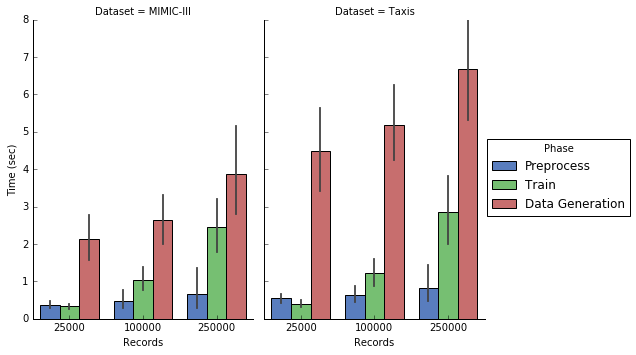

In [12]:
g = sns.factorplot(x='Records', y = 'Time', hue="Phase", data=timeRes,col = 'Dataset', size=5, kind="bar", 
                   palette="muted",aspect=0.7, hue_order=['Preprocess','Train','Data Generation'])
g.set_ylabels("Time (sec)")


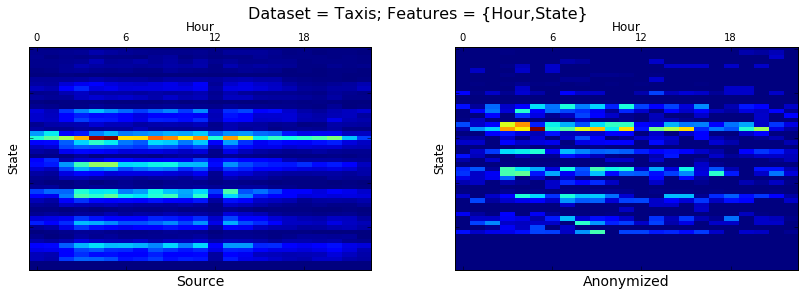

In [679]:
from sklearn.metrics import confusion_matrix
y_actu = d_train['site_id']
y_pred = d_train['hour'].astype(str)
mat = confusion_matrix(y_actu, y_pred)
fig, ax = plt.subplots(1,2)
#fig.set_figheight(8)
fig.set_figwidth(14)
ax[0].matshow(mat[:50,-24:-1], cmap=plt.cm.jet, aspect=0.3)
ax[0].set_xlabel('Source', fontsize=14)
ax[0].set_ylabel('State', fontsize=12)
ax[0].set_title('Hour', fontsize=12)
ax[0].set_xticks(np.arange(0, 24, 6))
ax[0].set_yticklabels([])

y_actu = d_fab['site_id']
y_pred = d_fab['hour'].astype(str)
mat = confusion_matrix(y_actu, y_pred)
ax[1].matshow(mat[:50,-24:-1], cmap=plt.cm.jet, aspect=0.3)
ax[1].set_xlabel('Anonymized', fontsize=14)
ax[1].set_ylabel('State', fontsize=12)
ax[1].set_title('Hour', fontsize=12)
ax[1].set_xticks(np.arange(0, 24, 6))
ax[1].set_yticklabels([])
#ax[l].set_xticklabels([])
plt.text(-3, -6, 'Dataset = Taxis; Features = {Hour,State}',fontsize=16, \
      horizontalalignment='center', verticalalignment='bottom')#, \
plt.show()

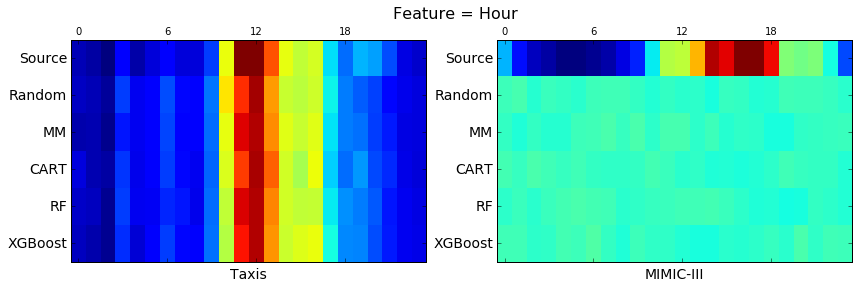

In [683]:
#subset =statsRes.loc[statsRes['Feature'].isin(['Mean Sequance Length']),:]
subset =statsRes.loc[statsRes['Feature'].isin(['hour']),['Version','Dataset','Records','Method','Value','Frequency']]
subset['Value'] = subset['Value'].astype(int)
#sns.factorplot(x = 'Value',y = 'Frequency',col = 'Dataset', hue = 'Version' ,row = 'Method',
#               data=subset,kind='bar',aspect=1, size = 5)

a = subset[(subset['Dataset']=='Taxis') & (subset['Version']=='Source')& (subset['Method']=='RF')].groupby(['Value']).sum()['Frequency']
b = subset[(subset['Dataset']=='Taxis') & (subset['Version']=='Anonymized')& (subset['Method']=='Random')].groupby(['Value']).sum()['Frequency']
c = subset[(subset['Dataset']=='Taxis') & (subset['Version']=='Anonymized')& (subset['Method']=='MM')].groupby(['Value']).sum()['Frequency']
d = subset[(subset['Dataset']=='Taxis') & (subset['Version']=='Anonymized')& (subset['Method']=='CART')].groupby(['Value']).sum()['Frequency']
e = subset[(subset['Dataset']=='Taxis') & (subset['Version']=='Anonymized')& (subset['Method']=='RF')].groupby(['Value']).sum()['Frequency']
f = subset[(subset['Dataset']=='Taxis') & (subset['Version']=='Anonymized')& (subset['Method']=='XGBoost')].groupby(['Value']).sum()['Frequency']

all_ = np.row_stack((a,b,c,d,e,f))
x_ticks_labels = ['','Source','Random','MM','CART','RF','XGBoost']
fig, ax = plt.subplots(1,2) 
#fig.set_figheight(8)
fig.set_figwidth(14)

ax[0].matshow(all_, cmap=plt.cm.jet, aspect=2.5)

# Set number of ticks for x-axis
ax[0].set_yticklabels(x_ticks_labels, fontsize=14) #, rotation='vertical'
ax[0].set_xticks(np.arange(0, 24, 6))
ax[0].set_xlabel('Taxis', fontsize=14)
#ax[0].set_title('Hour', fontsize=12)

a = subset[(subset['Dataset']=='MIMIC-III') & (subset['Version']=='Source')& (subset['Method']=='RF')].groupby(['Value']).sum()['Frequency']
b = subset[(subset['Dataset']=='MIMIC-III') & (subset['Version']=='Anonymized')& (subset['Method']=='Random')].groupby(['Value']).sum()['Frequency']
c = subset[(subset['Dataset']=='MIMIC-III') & (subset['Version']=='Anonymized')& (subset['Method']=='MM')].groupby(['Value']).sum()['Frequency']
d = subset[(subset['Dataset']=='MIMIC-III') & (subset['Version']=='Anonymized')& (subset['Method']=='CART')].groupby(['Value']).sum()['Frequency']
e = subset[(subset['Dataset']=='MIMIC-III') & (subset['Version']=='Anonymized')& (subset['Method']=='RF')].groupby(['Value']).sum()['Frequency']
f = subset[(subset['Dataset']=='MIMIC-III') & (subset['Version']=='Anonymized')& (subset['Method']=='XGBoost')].groupby(['Value']).sum()['Frequency']

all_ = np.row_stack((a,b,c,d,e,f))
ax[1].matshow(all_, cmap=plt.cm.jet,aspect=2.5)

# Set number of ticks for x-axis
ax[1].set_yticklabels(x_ticks_labels, fontsize=14) #, rotation='vertical'
ax[1].set_xticks(np.arange(0, 24, 6))

ax[1].set_xlabel('MIMIC-III', fontsize=14)
plt.text(-3.3, -1, 'Feature = Hour',fontsize=16, \
      horizontalalignment='center', verticalalignment='bottom')#, \



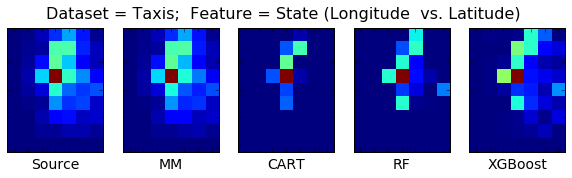

In [714]:
#subset =statsRes.loc[statsRes['Feature'].isin(['Mean Sequance Length']),:]
subset =statsRes.loc[(statsRes['Feature'].isin(['next_event']))&(statsRes['Value'].astype(str)!='-1'),['Version','Dataset','Records','Method','Value','Frequency']]
#sns.factorplot(x = 'Value',y = 'Frequency',col = 'Dataset', hue = 'Version' ,row = 'Method',
#               data=subset,kind='bar',aspect=1, size = 5)
a = subset[(subset['Dataset']=='Taxis') & (subset['Version']=='Source')& (subset['Method']=='RF')].groupby(['Value']).sum()['Frequency']
b = subset[(subset['Dataset']=='Taxis') & (subset['Version']=='Anonymized')& (subset['Method']=='Random')].groupby(['Value']).sum()['Frequency']
c = subset[(subset['Dataset']=='Taxis') & (subset['Version']=='Anonymized')& (subset['Method']=='MM')].groupby(['Value']).sum()['Frequency']
d = subset[(subset['Dataset']=='Taxis') & (subset['Version']=='Anonymized')& (subset['Method']=='CART')].groupby(['Value']).sum()['Frequency']
e = subset[(subset['Dataset']=='Taxis') & (subset['Version']=='Anonymized')& (subset['Method']=='RF')].groupby(['Value']).sum()['Frequency']
f = subset[(subset['Dataset']=='Taxis') & (subset['Version']=='Anonymized')& (subset['Method']=='XGBoost')].groupby(['Value']).sum()['Frequency']

names = ['Source','MM','CART','RF','XGBoost']
fig, ax = plt.subplots(1,5) 
fig.set_figwidth(10)
#fig.suptitle('Taxis', fontsize=14)
plt.text(-14, -1, 'Dataset = Taxis;  Feature = State (Longitude  vs. Latitude)',fontsize=16, \
      horizontalalignment='center', verticalalignment='bottom')#, \
      #transform=ax.transAxes)
x_r =[-8.64, -8.63, -8.62, -8.61, -8.6 , -8.59, -8.58, -8.57, -1.]
y_r =[ 0.  ,  41.13,  41.14,  41.15,  41.16,  41.17,  41.18]
for l, data in enumerate([a,c,d,e,f]):
    xy = np.matrix(pd.Series(data.index.values).str.split('_').apply(pd.Series).astype(float))
    xy[0] = np.squeeze(xy[0] )
    xy[1] = np.squeeze(xy[1] )
    tmp = np.c_[ xy, data.values ]
    tmp = pd.DataFrame(tmp)
    tmp=tmp.dropna()
    #tmp = tmp[~np.isnan(tmp).any(0),:]
    mat = np.zeros((len(x_r),len(y_r)))
    for i,x in enumerate(x_r):
        for j,y in enumerate(y_r):
            #tmp[(tmp.loc[tmp[:,0]==x)]&(tmp.loc[tmp[:,1]==y]),:]
            mat[i,j] = np.sum(tmp.loc[(tmp[0]==x)&(tmp[1]== y),2])

    #ax[l].matshow(all_, cmap=plt.cm.jet, aspect=2)
    #ax[l].set_title(names[l], fontsize=14)
    ax[l].matshow(np.matrix(mat ), cmap=plt.cm.jet,aspect=1)
    ax[l].set_xlabel(names[l], fontsize=14)
    # Turn off tick labels
    ax[l].set_yticklabels([])
    ax[l].set_xticklabels([])


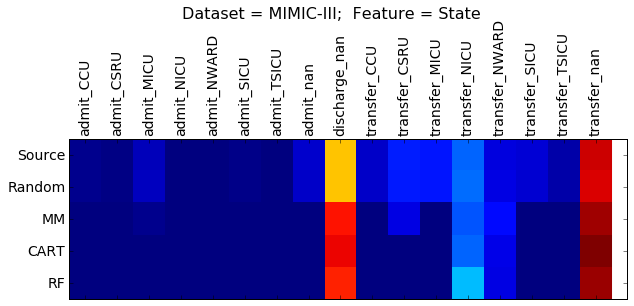

In [693]:
#subset =statsRes.loc[statsRes['Feature'].isin(['Mean Sequance Length']),:]
subset =statsRes.loc[(statsRes['Feature'].isin(['next_event'])&(statsRes['Value'].astype(str)!='-1')),['Version','Dataset','Records','Method','Value','Frequency']]
#sns.factorplot(x = 'Value',y = 'Frequency',col = 'Dataset', hue = 'Version' ,row = 'Method',
#               data=subset,kind='bar',aspect=1, size = 5)

a = subset[(subset['Dataset']=='MIMIC-III') & (subset['Version']=='Source')& (subset['Method']=='RF')].groupby(['Value']).sum()['Frequency']
b = subset[(subset['Dataset']=='MIMIC-III') & (subset['Version']=='Anonymized')& (subset['Method']=='Random')].groupby(['Value']).sum()['Frequency']
c = subset[(subset['Dataset']=='MIMIC-III') & (subset['Version']=='Anonymized')& (subset['Method']=='MM')].groupby(['Value']).sum()['Frequency']
d = subset[(subset['Dataset']=='MIMIC-III') & (subset['Version']=='Anonymized')& (subset['Method']=='CART')].groupby(['Value']).sum()['Frequency']
e = subset[(subset['Dataset']=='MIMIC-III') & (subset['Version']=='Anonymized')& (subset['Method']=='RF')].groupby(['Value']).sum()['Frequency']
f = subset[(subset['Dataset']=='MIMIC-III') & (subset['Version']=='Anonymized')& (subset['Method']=='XGBoost')].groupby(['Value']).sum()['Frequency']

all_ = pd.concat((a,b,c,d,e,f),axis=1,join='outer').fillna(0)
y_ticks_labels = ['','Source','Random','MM','CART','RF','XGBoost']
fig, ax = plt.subplots(1,1) 
#fig.set_figheight(10)
fig.set_figwidth(10)

ax.matshow(all_.T, cmap=plt.cm.jet, aspect=1)

# Set number of ticks for x-axis
ax.set_xticklabels(all_.index.values, fontsize=14, rotation='vertical')
ax.set_yticklabels(y_ticks_labels, fontsize=14) #, rotation='vertical'
ax.set_xticks(np.arange(0, 7, 1))
ax.set_xticks(np.arange(0, 18, 1))

plt.text(7.7, -4.2, 'Dataset = MIMIC-III;  Feature = State',fontsize=16, \
      horizontalalignment='center', verticalalignment='bottom')#, \


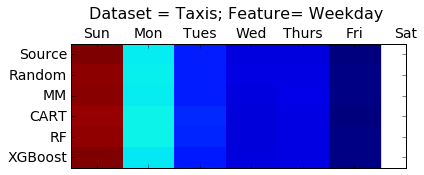

In [712]:
#subset =statsRes.loc[statsRes['Feature'].isin(['Mean Sequance Length']),:]
subset =statsRes.loc[statsRes['Feature'].isin(['weekday']),['Version','Dataset','Records','Method','Value','Frequency']]
subset['Value'] = subset['Value'].astype(int)
#sns.factorplot(x = 'Value',y = 'Frequency',col = 'Dataset', hue = 'Version' ,row = 'Method',
#               data=subset,kind='bar',aspect=1, size = 5)

a = subset[(subset['Dataset']=='Taxis') & (subset['Version']=='Source')& (subset['Method']=='RF')].groupby(['Value']).sum()['Frequency']
b = subset[(subset['Dataset']=='Taxis') & (subset['Version']=='Anonymized')& (subset['Method']=='Random')].groupby(['Value']).sum()['Frequency']
c = subset[(subset['Dataset']=='Taxis') & (subset['Version']=='Anonymized')& (subset['Method']=='MM')].groupby(['Value']).sum()['Frequency']
d = subset[(subset['Dataset']=='Taxis') & (subset['Version']=='Anonymized')& (subset['Method']=='CART')].groupby(['Value']).sum()['Frequency']
e = subset[(subset['Dataset']=='Taxis') & (subset['Version']=='Anonymized')& (subset['Method']=='RF')].groupby(['Value']).sum()['Frequency']
f = subset[(subset['Dataset']=='Taxis') & (subset['Version']=='Anonymized')& (subset['Method']=='XGBoost')].groupby(['Value']).sum()['Frequency']

all_ = np.row_stack((a,b,c,d,e,f))
x_ticks_labels = ['Sun','Mon','Tues','Wed','Thurs','Fri','Sat']
y_ticks_labels = ['','Source','Random','MM','CART','RF','XGBoost']

fig, ax = plt.subplots(1,1) 
fig.set_figheight(3)
#fig.set_figwidth(6)

ax.matshow(all_, cmap=plt.cm.jet, aspect=0.4)

# Set number of ticks for x-axis
ax.set_xticklabels(x_ticks_labels, fontsize=14) #, rotation='vertical'
ax.set_yticklabels(y_ticks_labels, fontsize=14) #, rotation='vertical'
ax.set_xticks(np.arange(0, 7, 1))
plt.text(2.7, -1.6, 'Dataset = Taxis; Feature= Weekday',fontsize=16, \
      horizontalalignment='center', verticalalignment='bottom')#, \



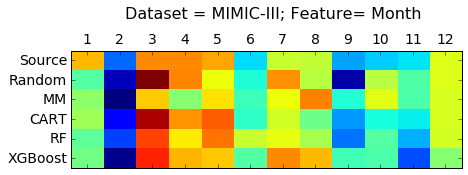

In [706]:
#subset =statsRes.loc[statsRes['Feature'].isin(['Mean Sequance Length']),:]
subset =statsRes.loc[statsRes['Feature'].isin(['month']),['Version','Dataset','Records','Method','Value','Frequency']]
subset['Value'] = subset['Value'].astype(int)
#sns.factorplot(x = 'Value',y = 'Frequency',col = 'Dataset', hue = 'Version' ,row = 'Method',
#               data=subset,kind='bar',aspect=1, size = 5)
x_ticks_labels = ['','Source','Random','MM','CART','RF','XGBoost']
y_ticks_labels = ['1','2','3','4','5','6','7','8','9','10','11','12']

fig, ax = plt.subplots(1,1) 
#fig.set_figheight(6)
fig.set_figwidth(7)


a = subset[(subset['Dataset']=='MIMIC-III') & (subset['Version']=='Source')& (subset['Method']=='RF')].groupby(['Value']).sum()['Frequency']
b = subset[(subset['Dataset']=='MIMIC-III') & (subset['Version']=='Anonymized')& (subset['Method']=='Random')].groupby(['Value']).sum()['Frequency']
c = subset[(subset['Dataset']=='MIMIC-III') & (subset['Version']=='Anonymized')& (subset['Method']=='MM')].groupby(['Value']).sum()['Frequency']
d = subset[(subset['Dataset']=='MIMIC-III') & (subset['Version']=='Anonymized')& (subset['Method']=='CART')].groupby(['Value']).sum()['Frequency']
e = subset[(subset['Dataset']=='MIMIC-III') & (subset['Version']=='Anonymized')& (subset['Method']=='RF')].groupby(['Value']).sum()['Frequency']
f = subset[(subset['Dataset']=='MIMIC-III') & (subset['Version']=='Anonymized')& (subset['Method']=='XGBoost')].groupby(['Value']).sum()['Frequency']

all_ = np.row_stack((a,b,c,d,e,f))
ax.matshow(all_, cmap=plt.cm.jet,aspect=0.6)

# Set number of ticks for x-axis
ax.set_yticklabels(x_ticks_labels, fontsize=14) #, rotation='vertical'
ax.set_xticks(np.arange(0, 12, 1))
ax.set_xticklabels(y_ticks_labels, fontsize=14) #, rotation='vertical'

plt.text(5.7, -2, 'Dataset = MIMIC-III; Feature= Month',fontsize=16, \
      horizontalalignment='center', verticalalignment='bottom')#, \



##### 

In [16]:
gd.to_csv(path_or_buf='./gd.csv')
d_fab.to_csv(path_or_buf='./d_fab.csv')
d_train.to_csv(path_or_buf='./d_train.csv')


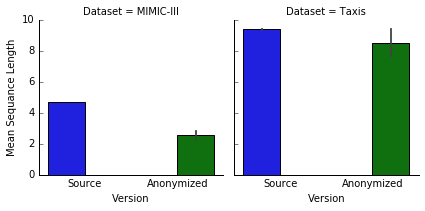

In [55]:
subset =statsRes.loc[statsRes['Feature'].isin(['Mean Sequance Length']),:]
gg = sns.factorplot(x = 'Version',y = 'Frequency',col = 'Dataset', hue = 'Version' ,
               data=subset,kind='bar',aspect=1, size = 3)
gg.set_ylabels('Mean Sequance Length')

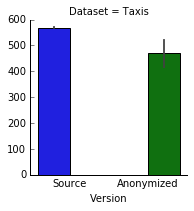

In [59]:
subset =statsRes.loc[statsRes['Feature'].isin(['Mean Sequance Duration']),:]
gg = sns.factorplot(x = 'Version',y = 'Frequency',col = 'Dataset', hue = 'Version' ,
               data=subset[subset['Dataset']=='Taxis'],kind='bar',aspect=1, size = 3)
gg.set_ylabels('')

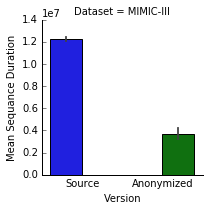

In [60]:
subset =statsRes.loc[statsRes['Feature'].isin(['Mean Sequance Duration']),:]
gg = sns.factorplot(x = 'Version',y = 'Frequency',col = 'Dataset', hue = 'Version' ,
               data=subset[subset['Dataset']=='MIMIC-III'],kind='bar',aspect=1, size = 3)
gg.set_ylabels('Mean Sequance Duration')

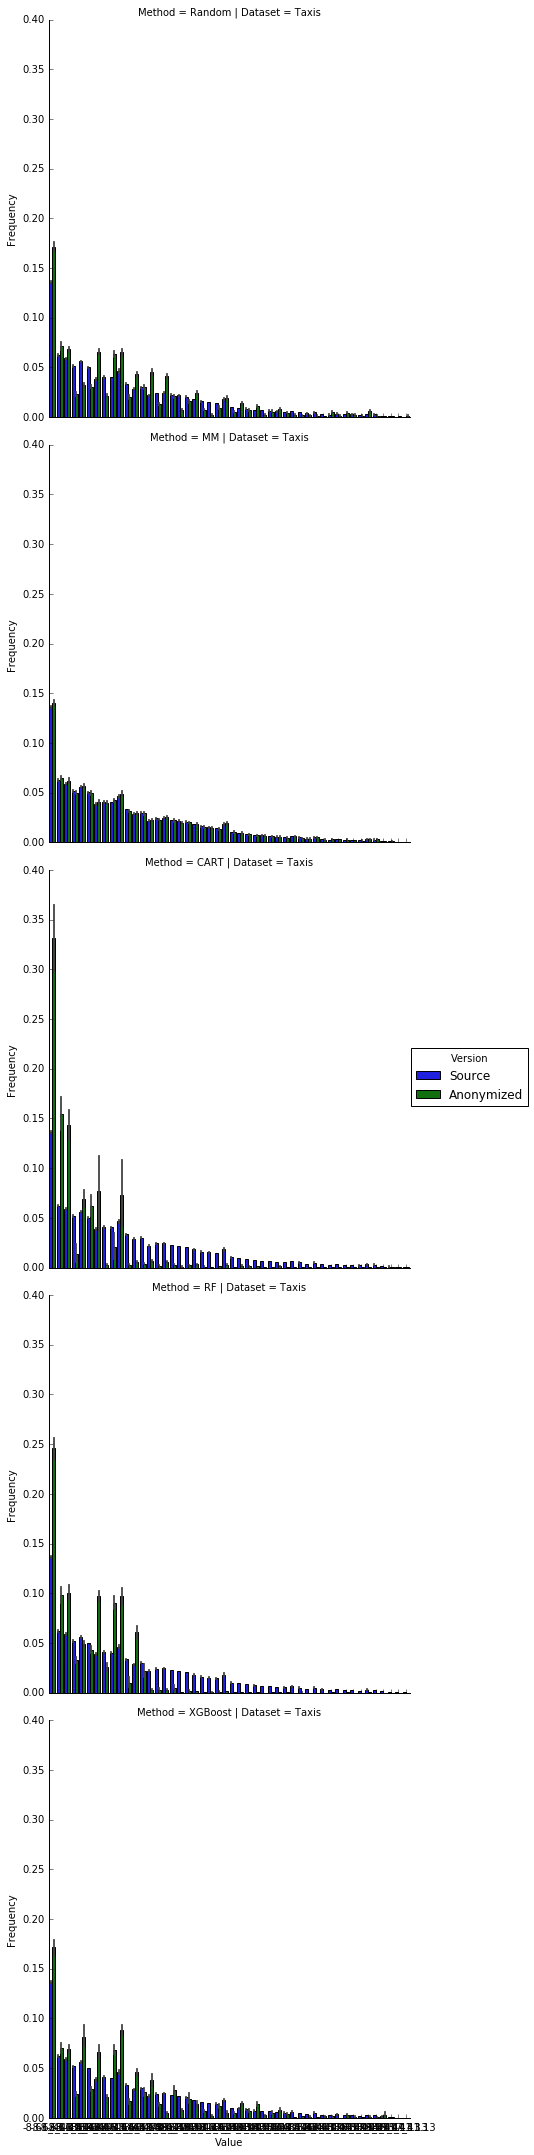

In [19]:
sns.factorplot(x = 'Value',y = 'Frequency',row='Method', col = 'Dataset', hue = 'Version' ,
               data=statsRes.loc[statsRes['Feature']=='site_id',:],kind='bar',aspect=1, size = 6)

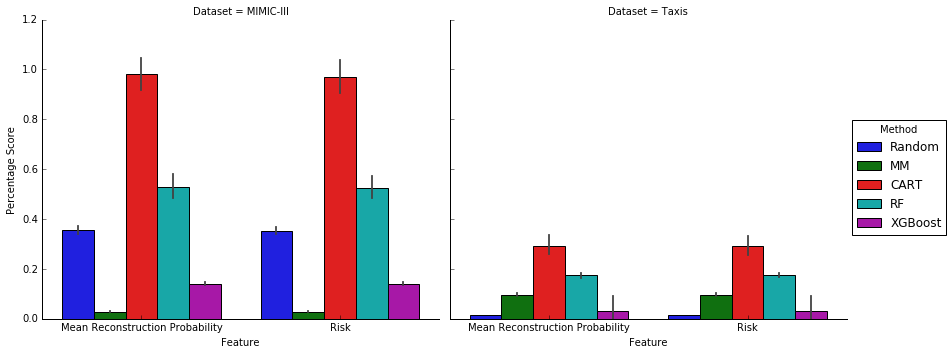

In [76]:
a =statsRes.loc[statsRes['Feature'].isin(['Mean Sequence Reconstruction Probability'])
                     & (statsRes['Dataset'].isin(['Taxis','MIMIC-III'])),:].copy()
a['Feature'] = 'Mean Reconstruction Probability'

b =statsRes.loc[statsRes['Feature'].isin(['Mean Sequence Reconstruction Probability'])
                     & (statsRes['Dataset'].isin(['Taxis','MIMIC-III'])),:].copy()
b['Frequency'] =  b['Frequency']* (1-b['Frequency'])
b['Feature'] = 'Risk'
subset = pd.concat([a,b])
subset['Frequency']=subset['Frequency']*100
subset.rename(columns = {'Frequency':'Percentage Score'}, inplace=True)
sns.factorplot(x = 'Feature',y = 'Percentage Score',col='Dataset', hue = 'Method' ,
               data=subset,kind='bar',aspect=1.2, size = 5)

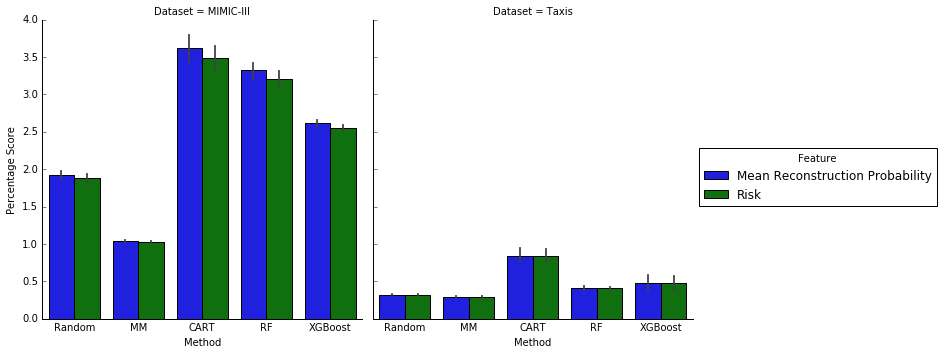

In [62]:
a =statsRes.loc[statsRes['Feature'].isin(['Mean Reconstruction Probability'])
                     & (statsRes['Dataset'].isin(['Taxis','MIMIC-III'])),:].copy()
b =statsRes.loc[statsRes['Feature'].isin(['Mean Reconstruction Probability'])
                     & (statsRes['Dataset'].isin(['Taxis','MIMIC-III'])),:].copy()
b['Frequency'] =  b['Frequency']* (1-b['Frequency'])
b['Feature'] = 'Risk'
subset = pd.concat([a,b])
subset['Frequency']=subset['Frequency']*100
subset.rename(columns = {'Frequency':'Percentage Score'}, inplace=True)
sns.factorplot(x = 'Method',y = 'Percentage Score',col='Dataset', hue = 'Feature' ,
               data=subset,kind='bar',aspect=1, size = 5)

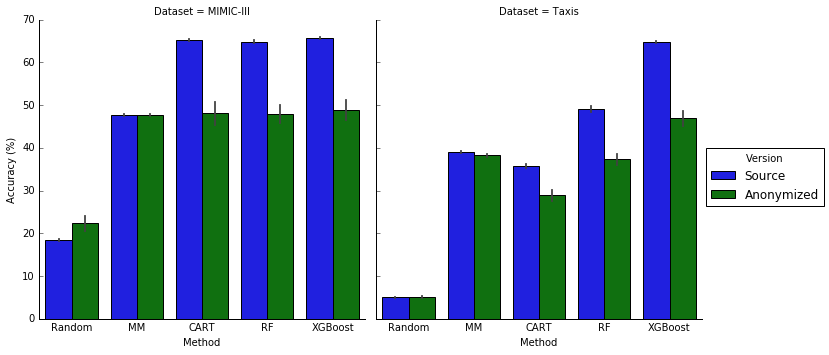

In [34]:
subset = results[(results['Dataset'].isin(['Taxis','MIMIC-III']))]#&(results['Version']=='Anonymized')]
subset['Accuracy (State Transitions)'] = subset['Accuracy (State Transitions)']*100
g = sns.factorplot(x = 'Method',y = 'Accuracy (State Transitions)',col = 'Dataset', hue = 'Version' ,
               data=subset,kind='bar',aspect=1, size = 5)
g.set_ylabels("Accuracy (%)")


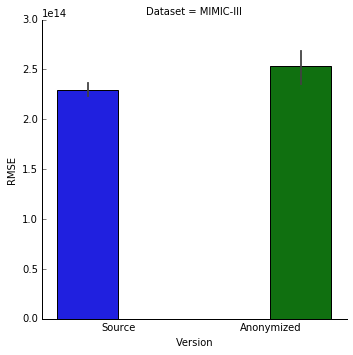

In [46]:
subset = results[(results['Dataset'].isin(['MIMIC-III']))]#&(results['Version']=='Anonymized')]
g=sns.factorplot(x = 'Version',y = 'RMSE (Transition Times)',hue = 'Version' , col = 'Dataset',
               data=subset,kind='bar',aspect=1, size = 5)
g.set_ylabels("RMSE")


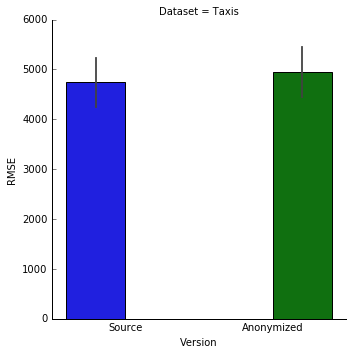

In [47]:
subset = results[(results['Dataset'].isin(['Taxis']))]#&(results['Version']=='Anonymized')]
g = sns.factorplot(x = 'Version',y = 'RMSE (Transition Times)',hue = 'Version' ,col = 'Dataset',
               data=subset,kind='bar',aspect=1, size = 5)
g.set_ylabels("RMSE")


In [16]:
sns.factorplot(x = 'Method',y = 'RMSE',col = 'Dataset', hue = 'W' ,data=res[res['Dataset']=='Taxis'],kind='bar',aspect=0.7)

NameError: name 'res' is not defined

# Experiments - Model

# comparing 4 algorithms

### Compare W 

In [43]:

np.random.seed(123)
datasets = ['mimic','Taxis']
#paths = [r'C:\Users\sigal\OneDrive - post.bgu.ac.il\sigal\decision tree based fabrication\mimicIII', r'C:\Users\sigal\OneDrive - post.bgu.ac.il\sigal\submissions\journal\data']
paths = ['./','./']
features = [['SUBJECT_ID','INTIME','event_id',['GENDER','DOB']],['TRIP_ID','timestamp','site_id',['DAY_TYPE']]]
params = [{"eta":0.1},
          {"eta":0.1},
          {"min_samples_leaf":30,"max_depth":6, "max_features":0.8 },
          {"n_estimators":30, "min_samples_leaf":30,"max_depth":6, "max_features":0.1},
          {"eta":0.1, "max_depth":4,"num_rounds":10,"colsample_bytree":0.5,"nthread":8}]#num_rounds was 25
methods = ['Random','Markov','decisionTree','RF','xgboost']
k_fold = 10
rep=10
par = [['max_depth'],['max_depth'],['min_samples_leaf'],['min_samples_leaf'],['max_depth']]
values = [[{1}],[{1}],[{50}],[{50}],[{4}]]
min_freq = 0
vocab_size=300
W =[0,1,2,3,4]
res = None
data_sizes = [25000]#, 100000, 150000]
for i,data_size in enumerate(data_sizes):
    cur_Res = run_eventDim_experiments(datasets,paths, data_size,features, k_folds=k_fold, repeats = rep,methods=methods,  parameters=par, values=values, base_params=params, minFreq=min_freq, vocab_size=vocab_size, W=W)
    cur_Res['Records'] = data_size
    if i==0:
        res = cur_Res
    else:
        res = res.append(cur_Res,ignore_index=True)


IndexError: list index out of range

In [9]:
res.to_csv(path_or_buf='./J3_eventDim_res25k_10rep_W.csv')

In [10]:
res.loc[res['Method'] == 'decisionTree', 'Method'] = 'CART'
res.loc[res['Method'] == 'Markov', 'Method'] = 'MM'
res.loc[res['Method'] == 'xgboost', 'Method'] = 'XGBoost'
res.loc[res['Dataset'] == 'mimic', 'Dataset'] = 'MIMIC-III'
#res.loc[res['Dataset'] == 'NYTaxi', 'Dataset'] = 'Taxis'

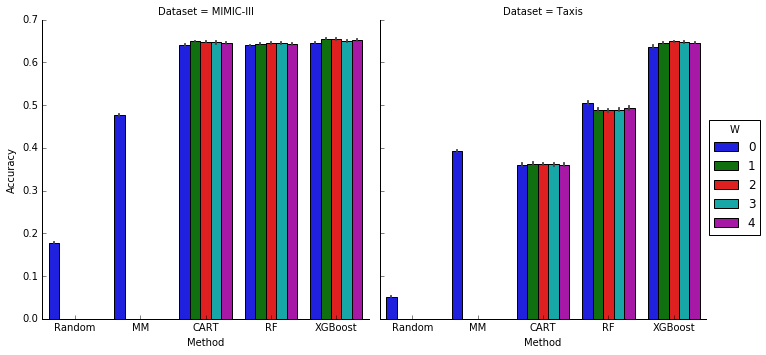

In [15]:
subset = res.loc[(res['W']==0) | (res['Method'].isin(['CART','XGBoost','RF'])),:]
sns.factorplot(x = 'Method',y = 'Accuracy',col = 'Dataset', hue = 'W' ,data=subset,kind='bar',aspect=1, size = 5)

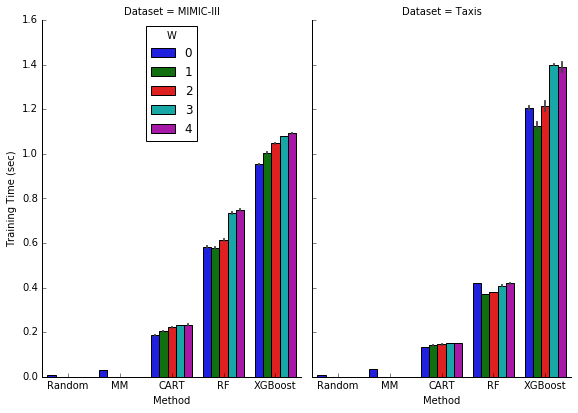

In [16]:
gg =sns.factorplot(x = 'Method',y = 'TrainTime',col = 'Dataset', hue = 'W' ,data=subset,kind='bar',aspect=0.7,size=5.8,legend_out=False)
gg.set_ylabels('Training Time (sec)')

In [8]:
res.to_csv(path_or_buf='./J2_FourMethods_res25k.csv')

In [12]:
res.loc[res['Method'] == 'decisionTree', 'Method'] = 'CART'
res.loc[res['Method'] == 'Markov', 'Method'] = 'MM'
res.loc[res['Method'] == 'xgboost', 'Method'] = 'XGBoost'
res.loc[res['Dataset'] == 'mimic', 'Dataset'] = 'MIMIC'
res.loc[res['Dataset'] == 'NYTaxi', 'Dataset'] = 'Taxis'

#res_A = res.copy()

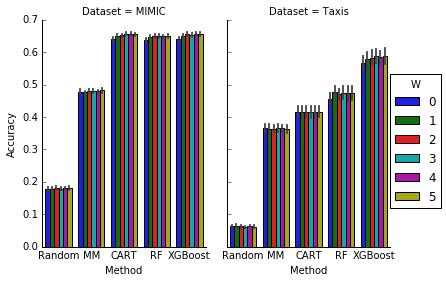

In [15]:
sns.factorplot(x = 'Method',y = 'Accuracy',col = 'Dataset', hue = 'W' ,data=res,kind='bar',aspect=0.7)

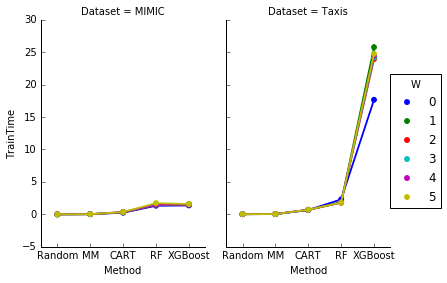

In [14]:
sns.factorplot(x = 'Method',y = 'TrainTime',col = 'Dataset', hue = 'W' ,data=res,kind='point',aspect=0.7)

### Comparing sample sizes

In [7]:
#checking Markov
import time
datasets = ['mimic','NYTaxi']
#paths = [r'C:\Users\sigal\OneDrive - post.bgu.ac.il\sigal\decision tree based fabrication\mimicIII', r'C:\Users\sigal\OneDrive - post.bgu.ac.il\sigal\submissions\journal\data']
paths = ['./','./']
features = [['SUBJECT_ID','INTIME','event_id',['GENDER','DOB']],['TRIP_ID','timestamp','site_id',['DAY_TYPE']]]
params = [{"eta":0.1},{"eta":0.1},{"min_samples_leaf":50,"max_depth":6 },{"n_estimators":30, "min_samples_leaf":50,"max_depth":6},{"eta":0.1, "max_depth":4,"num_rounds":10,"colsample_bytree":0.5,"nthread":8}]#num_rounds was 25
methods = ['Random','Markov','decisionTree','RF','xgboost']
k_fold = 10
rep=1
par = [['max_depth'],['max_depth'],['min_samples_leaf'],['min_samples_leaf'],['max_depth']]
values = [[{1}],[{1}],[{50}],[{50}],[{4}]]
min_freq = 0
vocab_size=300
W =[3]
res = None
data_sizes = [25000, 50000,100000]#, 100000, 150000]
for i,data_size in enumerate(data_sizes):
    cur_Res = run_eventDim_experiments(datasets,paths, data_size,features, k_folds=k_fold, repeats = rep,methods=methods,  parameters=par, values=values, base_params=params, minFreq=min_freq, vocab_size=vocab_size, W=W)
    cur_Res['Records'] = data_size
    if i==0:
        res = cur_Res
    else:
        res = res.append(cur_Res,ignore_index=True)


In [8]:
res

,Dataset,W,Fold,Repeat,Method,Parameter,Value,Accuracy,TrainTime,PredTime,Records
0,mimic,3,0,0,Random,max_depth,1,0.180466,0.005672,0.032706,25000
1,mimic,3,0,0,Markov,max_depth,1,0.473875,0.029511,2.055744,25000
2,mimic,3,0,0,decisionTree,min_samples_leaf,50,0.659164,0.346073,0.021314,25000
3,mimic,3,0,0,RF,min_samples_leaf,50,0.650723,1.477123,0.053449,25000
4,mimic,3,0,0,xgboost,max_depth,4,0.653537,1.228957,0.066355,25000
5,mimic,3,1,0,Random,max_depth,1,0.165692,0.005004,0.034344,25000
6,mimic,3,1,0,Markov,max_depth,1,0.476803,0.027059,2.149052,25000
7,mimic,3,1,0,decisionTree,min_samples_leaf,50,0.655750,0.341241,0.021420,25000
8,mimic,3,1,0,RF,min_samples_leaf,50,0.639376,1.493155,0.053142,25000
9,mimic,3,1,0,xgboost,max_depth,4,0.646394,1.223667,0.067086,25000


In [9]:
res.to_csv(path_or_buf='./J2_FourMethods_res25k_sampleSizes.csv')

In [10]:
res.loc[res['Method'] == 'decisionTree', 'Method'] = 'CART'
res.loc[res['Method'] == 'Markov', 'Method'] = 'MM'
res.loc[res['Method'] == 'xgboost', 'Method'] = 'XGBoost'
res.loc[res['Dataset'] == 'mimic', 'Dataset'] = 'MIMIC'
res.loc[res['Dataset'] == 'NYTaxi', 'Dataset'] = 'Taxis'

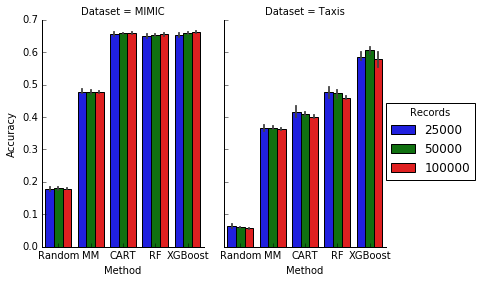

In [11]:
sns.factorplot(x = 'Method',y = 'Accuracy',col = 'Dataset', hue = 'Records' ,data=res,kind='bar',aspect=0.7)

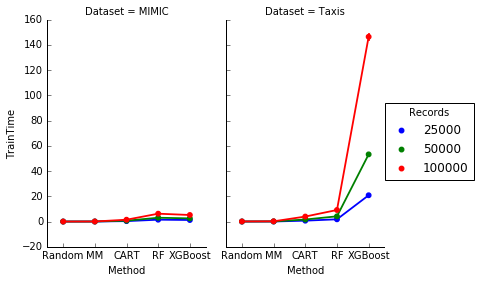

In [12]:
sns.factorplot(x = 'Method',y = 'TrainTime',col = 'Dataset', hue = 'Records' ,data=res,kind='point',aspect=0.7)

# evaluate transition times model

In [27]:
np.random.seed(123)
data_size = 25000
datasets = ['mimic','Taxis']
#paths = [r'C:\Users\sigal\OneDrive - post.bgu.ac.il\sigal\decision tree based fabrication\mimicIII', r'C:\Users\sigal\OneDrive - post.bgu.ac.il\sigal\decision tree based fabrication\d4d']
features = [['SUBJECT_ID','INTIME','event_id',['GENDER','DOB']],['TRIP_ID','timestamp','site_id',['DAY_TYPE']]]
paths = ['./','./']
methods = ['xgboost']
k_fold = 10
rep=10
par = [['max_features']]#,'max_depth','n_estimators']]
values = [[{0.1}]]#,{2}, {10}]]
#params = [{ "eta":0.1, "max_depth":2,"silent":1,"eval_metric":"rmse","lambda":0.3}]
#params = [{"eta":0.1, "max_depth":4,"colsample_bytree":0.5,"nthread":8}]
#params = [{"eta":0.1, "max_depth":4,"colsample_bytree":0.5,"nthread":8}]
params = [{ "max_features":0.1, "max_depth":2,"n_estimators":10}]
min_freq = 0
vocab_size=300

#timeDim_Res = run_timeDim_experiments(datasets,paths, data_size,features, k_folds=k_fold, repeats = rep,methods=methods,  parameters=par, 
 #                                 values=values, base_params=params, minFreq=min_freq, vocab_size=vocab_size,rounds=100)

W =[0,1,2,3]
res = None
data_sizes = [25000]#, 100000, 150000]
for i,data_size in enumerate(data_sizes):
    cur_Res = run_timeDim_experiments(datasets,paths, data_size,features, k_folds=k_fold, repeats = rep,methods=methods,  parameters=par, 
                                  values=values, base_params=params, minFreq=min_freq, vocab_size=vocab_size,rounds=100,W=W)
    cur_Res['Records'] = data_size
    if i==0:
        res = cur_Res
    else:
        res = res.append(cur_Res,ignore_index=True)


In [28]:
res.to_csv(path_or_buf='./J3_timeDim_res25k_10rep_Wonly.csv')

In [29]:
res.loc[res['Method'] == 'xgboost', 'Method'] = 'XGBoost'
res.loc[res['Dataset'] == 'mimic', 'Dataset'] = 'MIMIC-III'


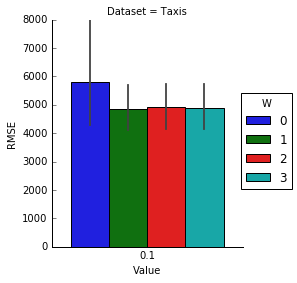

In [42]:
sns.factorplot(x = 'Value',y = 'RMSE',col = 'Dataset', hue = 'W' ,
               data=res[(res['Dataset']=='Taxis')],kind='bar',aspect=0.9)

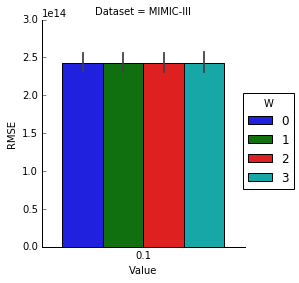

In [32]:
sns.factorplot(x = 'Value',y = 'RMSE',col = 'Dataset', hue = 'W' ,
               data=res[(res['Dataset']=='MIMIC-III')],kind='bar',aspect=0.9)

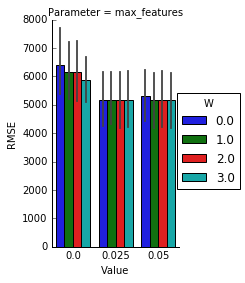

In [12]:
sns.factorplot(x = 'Value',y = 'RMSE',col = 'Parameter', hue = 'W' ,
               data=res[(res['Dataset']=='Taxis') & 
                (res['Parameter']=='max_features')].fillna(0),kind='bar',aspect=0.7)

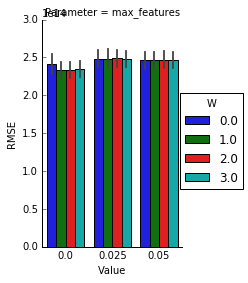

In [13]:
sns.factorplot(x = 'Value',y = 'RMSE',col = 'Parameter', hue = 'W' ,
               data=res[(res['Dataset']=='MIMIC') & 
                (res['Parameter']=='max_features')].fillna(0),kind='bar',aspect=0.7)

In [11]:
res

,Dataset,W,Fold,Repeat,Method,Parameter,Value,RMSE,R^2,TrainTime,PredTime,Records
0,MIMIC,0,0,0,XGBoost,max_features,0.025,2.911056e+14,0.004491,0.091948,0.009973,25000
1,MIMIC,0,0,1,XGBoost,max_features,0.025,2.901526e+14,0.007750,0.087313,0.009898,25000
2,MIMIC,0,0,2,XGBoost,max_features,0.025,2.871152e+14,0.018137,0.080645,0.009490,25000
3,MIMIC,0,0,3,XGBoost,max_features,0.025,2.892200e+14,0.010939,0.077751,0.009643,25000
4,MIMIC,0,0,4,XGBoost,max_features,0.025,2.909365e+14,0.005069,0.080197,0.009612,25000
5,MIMIC,0,0,5,XGBoost,max_features,0.025,2.919428e+14,0.001628,0.079082,0.009707,25000
6,MIMIC,0,0,6,XGBoost,max_features,0.025,2.874056e+14,0.017144,0.080653,0.009569,25000
7,MIMIC,0,0,7,XGBoost,max_features,0.025,2.922631e+14,0.000532,0.080841,0.009748,25000
8,MIMIC,0,0,8,XGBoost,max_features,0.025,2.863948e+14,0.020601,0.079647,0.009539,25000
9,MIMIC,0,0,9,XGBoost,max_features,0.025,2.870023e+14,0.018523,0.079511,0.009758,25000


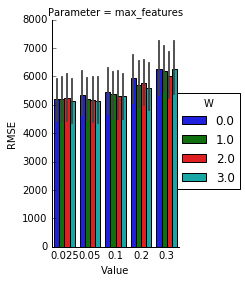

In [48]:
sns.factorplot(x = 'Value',y = 'RMSE',col = 'Parameter', hue = 'W' ,
               data=res[(res['Dataset']=='Taxis') & 
                (res['Parameter']=='max_features')],kind='bar',aspect=0.7)

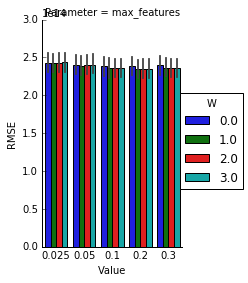

In [49]:
sns.factorplot(x = 'Value',y = 'RMSE',col = 'Parameter', hue = 'W' ,
               data=res[(res['Dataset']=='MIMIC') & 
                (res['Parameter']=='max_features')],kind='bar',aspect=0.7)

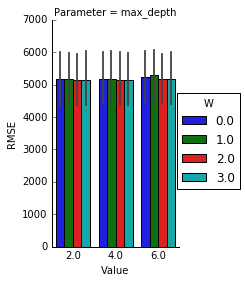

In [50]:
sns.factorplot(x = 'Value',y = 'RMSE',col = 'Parameter', hue = 'W' ,data=res[(res['Dataset']=='Taxis') & 
                (res['Parameter']=='max_depth')],kind='bar',aspect=0.7)

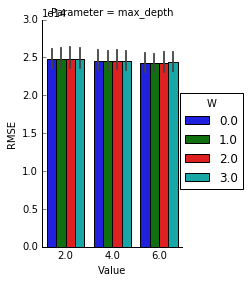

In [51]:
sns.factorplot(x = 'Value',y = 'RMSE',col = 'Parameter', hue = 'W' ,data=res[(res['Dataset']=='MIMIC') & 
                (res['Parameter']=='max_depth')],kind='bar',aspect=0.7)

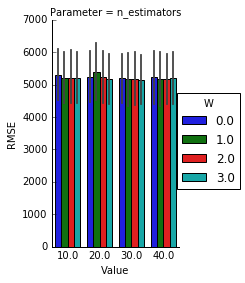

In [52]:
sns.factorplot(x = 'Value',y = 'RMSE',col = 'Parameter', hue = 'W' ,data=res[(res['Dataset']=='Taxis') & 
                (res['Parameter']=='n_estimators')],kind='bar',aspect=0.7)

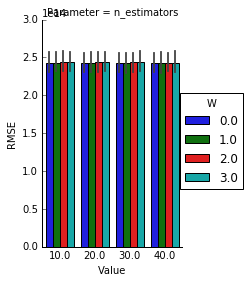

In [53]:
sns.factorplot(x = 'Value',y = 'RMSE',col = 'Parameter', hue = 'W' ,data=res[(res['Dataset']=='MIMIC') & 
                (res['Parameter']=='n_estimators')],kind='bar',aspect=0.7)